## Figure 5 Code to Produce Figures

This figure will focus on the presentation of Motif Analysis.

In [1]:
# importing packages
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import networkx as nx
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (10,10)
sns.set_theme(style="whitegrid")
results_folder = "all_cells_results"
random.seed(747)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def invert_dict(original_dict):
    inverted_dict = {}
    for key, items in original_dict.items():
        for item in items:
            if item not in inverted_dict:
                inverted_dict[item] = [key]
            else:
                inverted_dict[item].append(key)
    return inverted_dict

### Developing Connectome Network Graph

In [3]:
### Insert Code from Sai involving Connectome Network

### Load in Data from LSMMData Wrangler

In [4]:
# Import Stefan's Library for Data Management of V1DD
from lsmm_data import LSMMData

with open('v1dd_wrangler_input_dict.json') as f:
    loaded_json = json.load(f)
v1dd_data_all_to_all = LSMMData.LSMMData(loaded_json)
tables = v1dd_data_all_to_all.data
params = v1dd_data_all_to_all.params
dirs = v1dd_data_all_to_all.dirs
mappings = v1dd_data_all_to_all.mappings

Generating Connectome...


100%|██████████| 137706/137706 [00:14<00:00, 9641.40it/s]


Generating Connectome...


100%|██████████| 137706/137706 [00:19<00:00, 6937.54it/s]


In [5]:
tables['structural'].keys()

dict_keys(['post_cell', 'pre_cell', 'synapse', 'synapse_count_connectome', 'binary_connectome', 'summed_size_connectome', 'averaged_size_connectome'])

In [6]:
binary_connectome = tables['structural']['binary_connectome']
synapse_count_connectome = tables['structural']['synapse_count_connectome']
summed_size_connectome = tables['structural']['summed_size_connectome']
average_size_connectome = tables['structural']['averaged_size_connectome']

In [7]:
### Produce a dictionary for Assemblies by Coregistered
assemblies_by_coregistered = invert_dict(mappings['assemblies_by_connectome_index'])
# Produce Indexes for Assembly Cells and Non Assembly Cells
assembly_connectome_indexes = []
no_assembly_connectome_indexes = []
for key, val in mappings['assemblies_by_connectome_index'].items():
    if val == ['No A']:
        no_assembly_connectome_indexes.append(key)
    else:
        assembly_connectome_indexes.append(key)

In [8]:
# Produce a list of ids of around 50 Non-Reg cells
registered_ids = set(assembly_connectome_indexes) | set(no_assembly_connectome_indexes)
all_non_registered_ids = [i for i in range(0, binary_connectome.shape[0]) if i not in registered_ids]
random.seed(747) # set seed
non_registered_ids = random.sample(all_non_registered_ids, k= 50)
#non_registered_ids

In [9]:
# Grab Connectome with root ids, develop counts of first-order connections for assembly and no assembly set
assembly_first_order_connections = []
c_in_assembly = 0
non_assembly_first_order_connections = []
c_no_assembly = 0
for i in range(len(binary_connectome[0])):
    if i in assembly_connectome_indexes:
        c_in_assembly += 1
        assembly_first_order_connections.append(np.sum(binary_connectome[i,:]))
    elif i in no_assembly_connectome_indexes:
        c_no_assembly += 1
        non_assembly_first_order_connections.append(np.sum(binary_connectome[i,:]))

print("Number in Assembly Set:", c_in_assembly)
print("Number in No Assembly Set:", c_no_assembly)
print("Mean First-Order Binary Connections of Assembly Set:", np.mean(assembly_first_order_connections))
print("Mean First-Order Binary Connections of No Assembly Set:", np.mean(non_assembly_first_order_connections))

Number in Assembly Set: 43
Number in No Assembly Set: 12
Mean First-Order Binary Connections of Assembly Set: 46.395348837209305
Mean First-Order Binary Connections of No Assembly Set: 38.25


### First-Order Analysis with Binary Connectome

In [10]:
def produce_first_order_connections_plot(input_connections_dict: dict,
                                         total_cells : int,
                                         binary_counts: bool,
                                         syn_counts: bool, 
                                         directionality: str, 
                                         summed_psd : bool,
                                         average_psd: bool, 
                                         prob: bool, 
                                         intragroup: bool,
                                         grouped: bool,
                                         show_p_vals: bool, 
                                         fdr_correction: bool,
                                         include_non_registered = False):
    
    if binary_counts and syn_counts:
        raise ValueError("Must either be working with binary or synaptic count connectome.")
    if summed_psd and average_psd:
        raise ValueError("Must either be working with summed or average PSD values.")
    if (binary_counts or syn_counts) and (summed_psd or average_psd):
        raise ValueError("Must either be working with PSD or connectivity.")
    if (grouped and intragroup) and (not prob):
        raise ValueError("If inspecting grouped and intragroup, by default is already normalized. prob flag must be set to True.")
    if (not grouped) and include_non_registered:
        raise ValueError("Function is not capable of handling non-registered cells with ungrouped plots at the moment.")
    
    # Based on the connectome flags, save it in the right folder, set the correct y_label and plot title
    if binary_counts:
        connectome_desc = "Binary"
        folder = "binary_connectome"
        suffix = f"{directionality} Binary Connectivity"
        y_lab = "Binary Connections"
    elif summed_psd:
        connectome_desc = "Summed_PSD"
        folder = "summed_size_connectome"
        suffix = f"{directionality} Post Syanptic Strength"
        y_lab = "Summed Synaptic Strength (PSD in nm^3)"
    elif average_psd: 
        connectome_desc = "Average_PSD"
        folder = "average_size_connectome"
        suffix = f"{directionality} Post Syanptic Strength"
        y_lab = "Average Synaptic Strength (PSD in nm^3)"
    elif syn_counts:
        connectome_desc = "SynCounts"
        folder = "synapse_count_connectome"
        suffix = f"{directionality} First-Order Connectivity"
        y_lab = "Synaptic Counts"
    else:
        raise ValueError("Must specify which connectome is being used.")

    connections_dict = {}
    # If Required, produce probability arrays of connections
    if prob:
        for key in input_connections_dict.keys():
            if grouped and intragroup: # this case has already been normalized when producing the connections dictionary
                print("Probability Already Normalized.")
                connections_dict[key] = np.array(input_connections_dict[key])
            elif intragroup: # adding a flag for intragroup, and divide by number of cells in group
                print("Producing Probability of Connections with count of cells in group")
                connections_dict[key] = np.array(input_connections_dict[key]) / (len(input_connections_dict[key]) - 1)
            else:
                print(f"Producing Probability of Connections with total cell count: {total_cells}")
                connections_dict[key] = np.array(input_connections_dict[key]) / (total_cells - 1)
    else:
        for key in input_connections_dict.keys():
            connections_dict[key] = np.array(input_connections_dict[key])

    prefix = 'Grouped ' if grouped else ""
    suffix = "Intragroup " + suffix if intragroup else suffix
    suffix = "Probability of " + suffix if prob and binary_counts else "Normalized " + suffix if prob else suffix
    y_lab = "Probability of " + y_lab if prob and binary_counts else "Normalized " + y_lab if prob else y_lab

    if not grouped:
        all_arr = [connections_dict['No A']]
        x_ticks = ["No A"]
        arr_medians = [np.median(np.array(connections_dict['No A']))]
        p_values = [np.nan]
        # Sort the dictionary keys
        sorted_keys = sorted(connections_dict.keys(), key=lambda s: (0, 0) if s == 'No A' else (1, int(s.split()[1])))
        for key in sorted_keys:
            if key != 'No A':
                if len(connections_dict[key]) < 5:
                    print(f"No Empirical Testing Performed. Assembly {key} has less than 5 coregistered cells.")
                    continue
                all_arr.append(connections_dict[key])
                x_ticks.append(key)
                arr_medians.append(np.median(np.array(connections_dict[key])))
                p_values.append(stats.ranksums(connections_dict[key], connections_dict['No A'], 'greater').pvalue)
        
        # Perform False Discoery Correction for our P-Values
        p_values = np.array(p_values)
        print(p_values)
        if fdr_correction:
            p_values[1:] = stats.false_discovery_control(p_values[1:], method = 'bh')
        for i, val in enumerate(p_values):
            p_values[i] = '{:.3g}'.format(val, 5) if i != 0 else p_values[i]
    elif include_non_registered:
        all_arr = [connections_dict['No A'], connections_dict['All A'], connections_dict['Non-Reg']]
        x_ticks = ["No A", 'All A', 'Non-Reg']
        arr_medians = [np.median(np.array(connections_dict['No A'])), np.median(np.array(connections_dict['All A'])), np.median(np.array(connections_dict['Non-Reg']))]
        all_a_val = stats.ranksums(connections_dict['All A'], connections_dict['No A'], 'greater').pvalue
        non_registered_val = stats.ranksums(connections_dict['Non-Reg'], connections_dict['No A'], 'greater').pvalue
        p_values = [np.nan, '{:.3g}'.format(all_a_val, 5), '{:.3g}'.format(non_registered_val, 5)]
    else:
        all_arr = [connections_dict['No A'], connections_dict['All A']]
        x_ticks = ["No A", 'All A']
        arr_medians = [np.median(np.array(connections_dict['No A'])), np.median(np.array(connections_dict['All A']))]
        val = stats.ranksums(connections_dict['All A'], connections_dict['No A'], 'greater').pvalue
        p_values = [np.nan, '{:.3g}'.format(val, 5)]

    # Define Colors based on Signfiicance
    colors = ['lightgrey' if float(p_val) >= 0.05 or np.isnan(float(p_val)) else (.4, .6, .8, .5) for p_val in p_values]

    # Create a figure with specific size
    _, ax = plt.subplots(figsize=(12, 8))  # Width = 12 inches, Height = 6 inches

    sns.set_theme(style="whitegrid")
    sns.boxplot(data=all_arr,
                    notch= False, showcaps=True,
                    flierprops={"marker": "x"},
                    medianprops={"color": "coral"},
                    palette= colors,
                    ax = ax
                )
    ax.set_xticklabels(x_ticks, size = 14)
    ax.set_title(f'{prefix}Assembly Cell Involvement: {suffix}', size = 16)
    ax.set_ylabel(y_lab, size = 14)
    plt.xticks(rotation=45)

    # Create legend
    custom_legend = [plt.Line2D([0], [0], color='lightgrey', lw=7, label='No Significant Difference from No A'),
                    plt.Line2D([0], [0], color=(.4, .6, .8, .5), lw=7, label='Significant Difference from No A')]
    plt.legend(handles=custom_legend, loc='best')

    # If you want to print P-Values, place them on the plot above the median

    if show_p_vals:
        medians = np.array(arr_medians)
        vertical_offset = medians * 0.005 # offset from median for display
            
        for xtick in ax.get_xticks():
            if xtick != 0:
                ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick],  # type: ignore
                        horizontalalignment='center', fontsize=10, color='black', weight='semibold')

    desc = "Grouped" if grouped else "All"
    fig_title = f"{directionality}_{connectome_desc}_First_Order_{desc}_Assemblies_Boxplot.png"
    fig_title = "Intragroup_" + fig_title if intragroup else fig_title
    fig_title = "Normalized_" + fig_title if prob else fig_title
    
    plt.savefig(f'{results_folder}/{folder}/{fig_title}', dpi = 1200)
    plt.tight_layout()
    plt.show()

In [11]:
### Produce Plot for each assembly
coregistered_cell_indexes = mappings['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings['connectome_indexes_by_assembly']['No A']

In [12]:
# Produce Counts for Inbound and Outbound Connections
outbound_binary_first_order_connections = {}
inbound_binary_first_order_connections = {}
outbound_binary_intragroup_first_order_connections = {}
inbound_binary_intragroup_first_order_connections = {}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        outbound_binary_first_order_connections[A] = []
        inbound_binary_first_order_connections[A] = []
        outbound_binary_intragroup_first_order_connections[A] = []
        inbound_binary_intragroup_first_order_connections[A] = []
        for c_index in assemblies_by_coregistered[A]:
            outbound_binary_first_order_connections[A].append(np.sum(binary_connectome[c_index,:]))
            inbound_binary_first_order_connections[A].append(np.sum(binary_connectome[:,c_index]))
            outbound_binary_intragroup_first_order_connections[A].append(np.sum(binary_connectome[c_index,assemblies_by_coregistered[A]]))
            inbound_binary_intragroup_first_order_connections[A].append(np.sum(binary_connectome[assemblies_by_coregistered[A],c_index]))

print("Outbound Binary: ", outbound_binary_first_order_connections)
print("Inbound Binary: ", inbound_binary_first_order_connections)
print("Outbound Binary Intragroup: ", outbound_binary_intragroup_first_order_connections)
print("Inbound Binary Intragroup: ", inbound_binary_intragroup_first_order_connections)

Outbound Binary:  {'A 1': [76.0, 47.0, 40.0, 56.0, 30.0, 81.0, 54.0, 53.0, 69.0, 63.0, 29.0, 36.0, 30.0, 15.0, 46.0, 51.0, 41.0, 35.0, 55.0, 51.0, 48.0], 'A 3': [47.0, 30.0, 63.0, 36.0, 30.0, 35.0, 48.0, 31.0, 36.0, 27.0], 'A 4': [47.0, 54.0, 53.0, 51.0, 35.0, 46.0, 89.0, 39.0, 40.0, 62.0], 'A 5': [47.0, 56.0, 36.0, 46.0, 40.0, 62.0, 43.0, 30.0], 'A 7': [47.0, 56.0, 54.0, 53.0, 36.0, 40.0, 62.0, 43.0], 'A 8': [47.0, 54.0, 53.0, 69.0, 48.0, 36.0, 40.0, 62.0], 'A 10': [56.0, 44.0, 59.0, 52.0, 48.0], 'A 2': [69.0, 30.0, 55.0, 27.0, 40.0, 37.0, 44.0, 46.0, 59.0], 'No A': [20.0, 52.0, 37.0, 44.0, 47.0, 49.0, 48.0, 39.0, 30.0, 18.0, 41.0, 34.0]}
Inbound Binary:  {'A 1': [118.0, 57.0, 103.0, 84.0, 118.0, 95.0, 88.0, 87.0, 115.0, 110.0, 73.0, 104.0, 100.0, 64.0, 75.0, 78.0, 95.0, 77.0, 39.0, 58.0, 82.0], 'A 3': [57.0, 118.0, 110.0, 104.0, 100.0, 77.0, 82.0, 86.0, 68.0, 28.0], 'A 4': [57.0, 88.0, 87.0, 78.0, 77.0, 58.0, 100.0, 66.0, 81.0, 50.0], 'A 5': [57.0, 84.0, 104.0, 58.0, 81.0, 50.0, 106.

In [13]:
# Produce Grouped Counts for Inbound and Outbound Connections
grouped_outbound_binary_first_order_connections = {'No A': [], "All A": [], 'Non-Reg': []}
grouped_inbound_binary_first_order_connections = {'No A': [], "All A": [], 'Non-Reg': []}
grouped_intragroup_outbound_binary_first_order_connections = {'No A': [], "All A": [], 'Non-Reg': []}
grouped_intragroup_inbound_binary_first_order_connections = {'No A': [], "All A": [], 'Non-Reg': []}

non_intragroup_assembly_indexes = set()
for A, group_indexes in assemblies_by_coregistered.items():
    if len(group_indexes) < 2:
        continue
    
    for c_index in group_indexes:
        outbound_sum = np.sum(binary_connectome[c_index,:])
        inbound_sum = np.sum(binary_connectome[:,c_index])
        # Will normalize already by all possible connections in group
        intragroup_outbound_sum = np.sum(binary_connectome[c_index,group_indexes]) / (len(group_indexes) - 1)
        intragroup_inbound_sum = np.sum(binary_connectome[group_indexes,c_index]) / (len(group_indexes) - 1)
        if A == 'No A':
            grouped_outbound_binary_first_order_connections['No A'].append(outbound_sum)
            grouped_inbound_binary_first_order_connections['No A'].append(inbound_sum)
            grouped_intragroup_outbound_binary_first_order_connections['No A'].append(intragroup_outbound_sum)
            grouped_intragroup_inbound_binary_first_order_connections['No A'].append(intragroup_inbound_sum)
        else:
            grouped_intragroup_outbound_binary_first_order_connections['All A'].append(intragroup_outbound_sum)
            grouped_intragroup_inbound_binary_first_order_connections['All A'].append(intragroup_inbound_sum)
            # Make sure there is no double counting in non-intragroup analysis
            if c_index not in non_intragroup_assembly_indexes:
                grouped_outbound_binary_first_order_connections['All A'].append(outbound_sum)
                grouped_inbound_binary_first_order_connections['All A'].append(inbound_sum)
                non_intragroup_assembly_indexes.add(c_index)

# Add Analysis for non-registered ids
for c_index in non_registered_ids:
    outbound_sum = np.sum(binary_connectome[c_index,:])
    inbound_sum = np.sum(binary_connectome[:,c_index])
    grouped_outbound_binary_first_order_connections['Non-Reg'].append(outbound_sum)
    grouped_inbound_binary_first_order_connections['Non-Reg'].append(inbound_sum)

print("Grouped Outbound Binary: ", grouped_outbound_binary_first_order_connections)
print("Grouped Inbound Binary: ", grouped_inbound_binary_first_order_connections)
print("Grouped Outbound Binary Intragroup: ", grouped_intragroup_outbound_binary_first_order_connections)
print("Grouped Inbound Binary Intragroup: ", grouped_intragroup_inbound_binary_first_order_connections)

Grouped Outbound Binary:  {'No A': [20.0, 52.0, 37.0, 44.0, 47.0, 49.0, 48.0, 39.0, 30.0, 18.0, 41.0, 34.0], 'All A': [76.0, 47.0, 40.0, 56.0, 30.0, 81.0, 54.0, 53.0, 69.0, 63.0, 29.0, 36.0, 30.0, 15.0, 46.0, 51.0, 41.0, 35.0, 55.0, 51.0, 48.0, 31.0, 36.0, 27.0, 46.0, 89.0, 39.0, 40.0, 62.0, 43.0, 30.0, 44.0, 59.0, 52.0, 48.0, 27.0, 40.0, 37.0, 46.0, 80.0, 28.0], 'Non-Reg': [69.0, 62.0, 44.0, 81.0, 29.0, 7.0, 31.0, 95.0, 142.0, 72.0, 56.0, 317.0, 138.0, 207.0, 75.0, 52.0, 33.0, 133.0, 5.0, 59.0, 51.0, 15.0, 43.0, 27.0, 6.0, 216.0, 109.0, 28.0, 16.0, 48.0, 96.0, 90.0, 263.0, 43.0, 74.0, 21.0, 256.0, 158.0, 117.0, 31.0, 8.0, 65.0, 13.0, 63.0, 35.0, 32.0, 61.0, 60.0, 50.0, 31.0]}
Grouped Inbound Binary:  {'No A': [76.0, 96.0, 89.0, 91.0, 66.0, 102.0, 83.0, 54.0, 86.0, 50.0, 66.0, 63.0], 'All A': [118.0, 57.0, 103.0, 84.0, 118.0, 95.0, 88.0, 87.0, 115.0, 110.0, 73.0, 104.0, 100.0, 64.0, 75.0, 78.0, 95.0, 77.0, 39.0, 58.0, 82.0, 86.0, 68.0, 28.0, 58.0, 100.0, 66.0, 81.0, 50.0, 106.0, 60.0, 

[       nan 0.04430325 0.18717993 0.70107831 0.02047285 0.17726974
 0.02457042 0.01537678 0.00885303]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


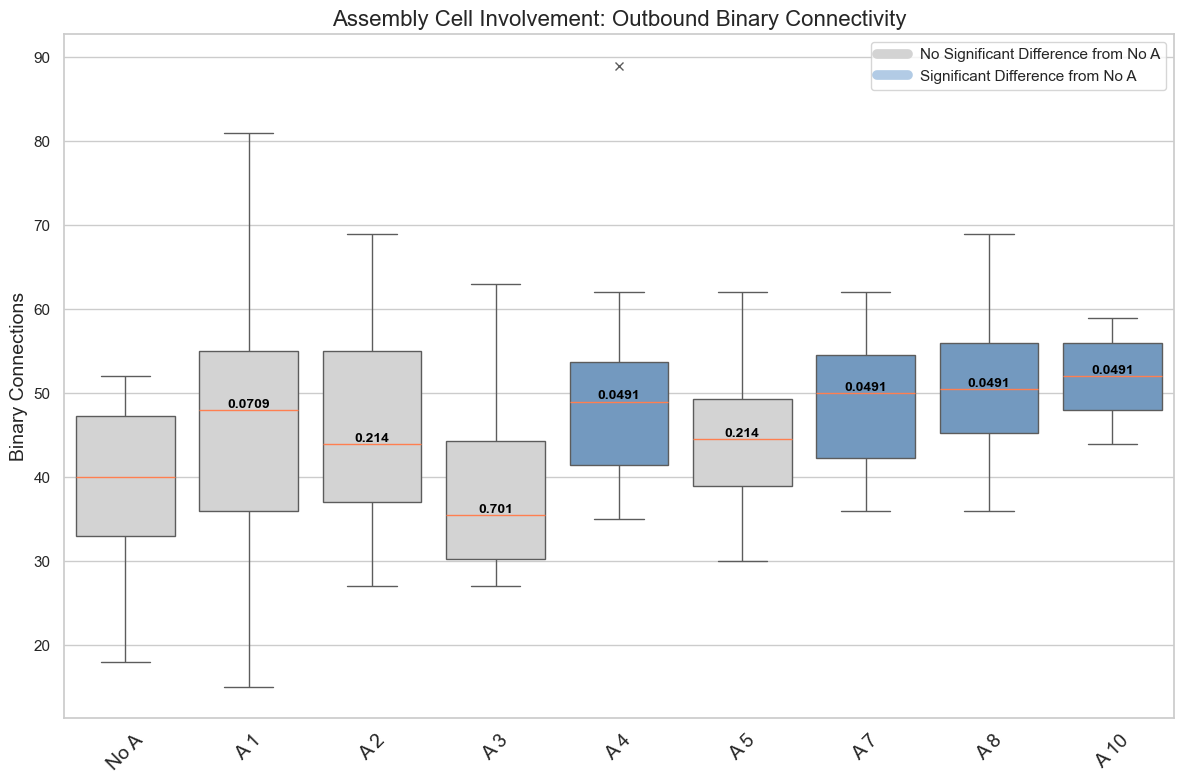

In [14]:
## Produce Outbound First-Order Connections Plot
produce_first_order_connections_plot(input_connections_dict = outbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
[       nan 0.04430325 0.18717993 0.70107831 0.02047285 0.17726974
 0.02457042 0.01537678 0.00885303]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


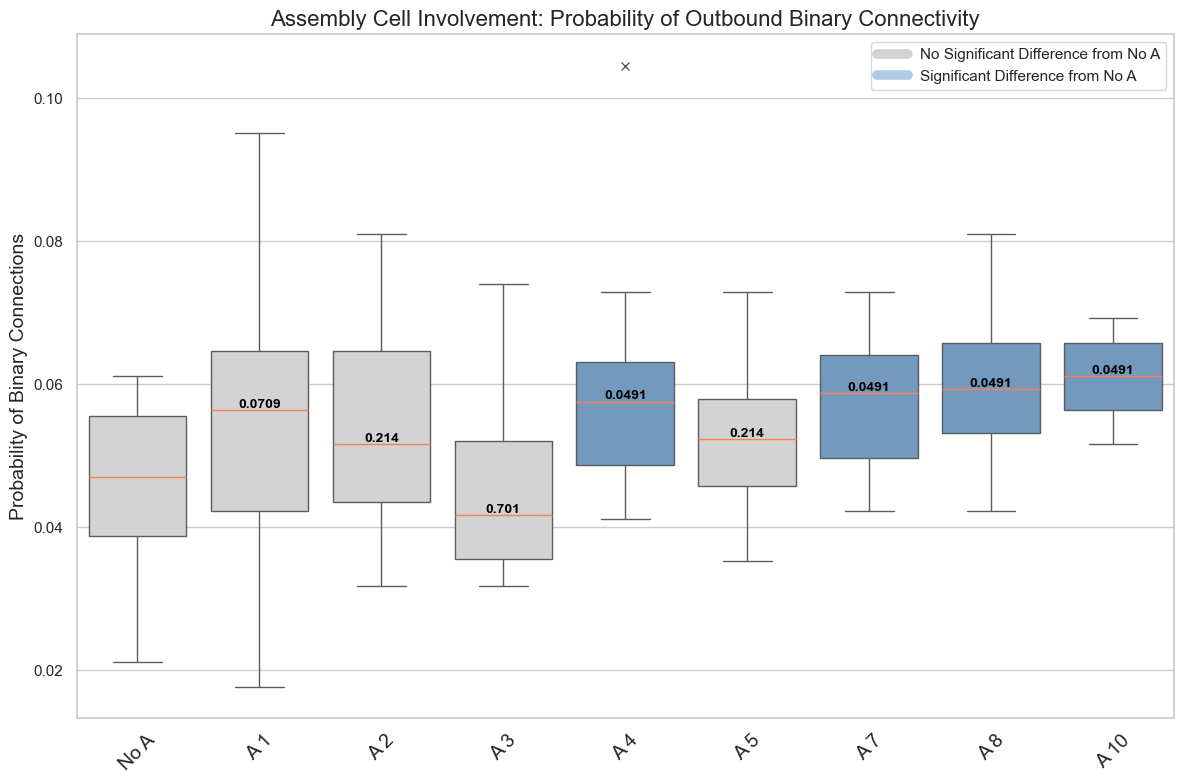

In [15]:
## Produce Outbound First-Order Connections Plot
produce_first_order_connections_plot(input_connections_dict = outbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

[       nan 0.09512463 0.29701617 0.18668901 0.66589185 0.63577291
 0.48461428 0.51538572 0.47898363]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


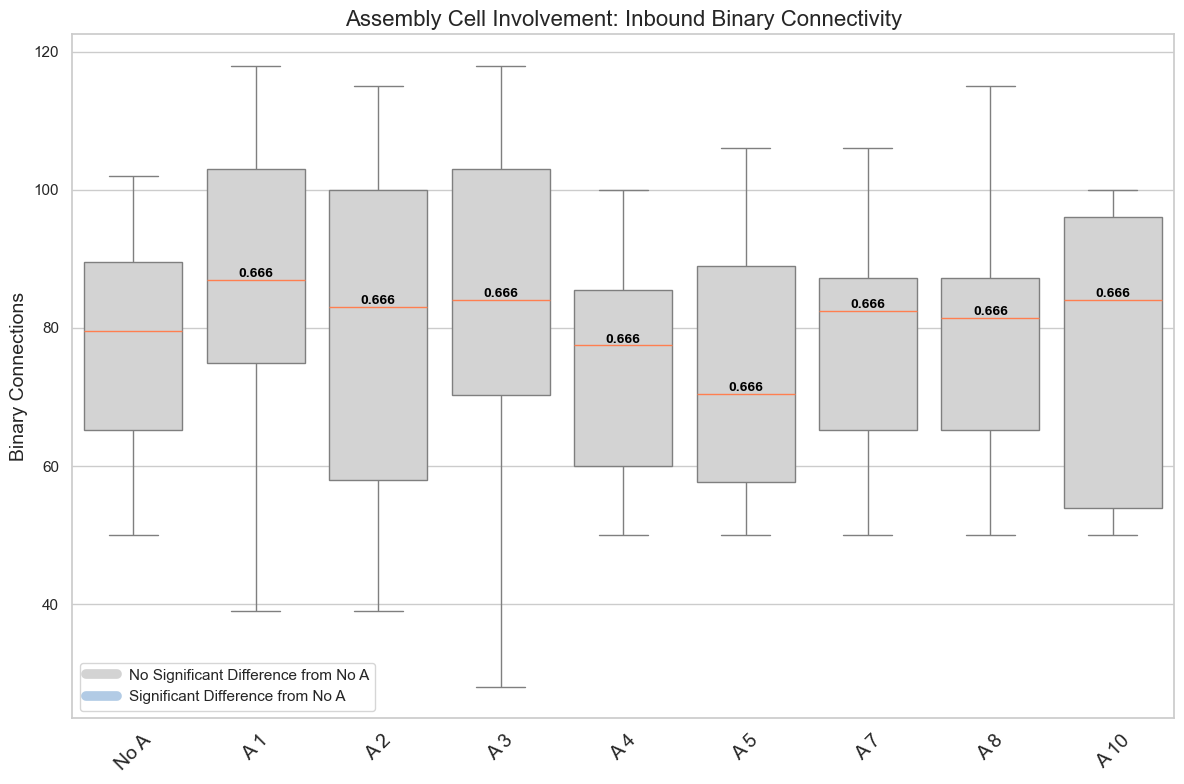

In [16]:
## Produce Inbound First-Order Connections Plot
produce_first_order_connections_plot(input_connections_dict = inbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
[       nan 0.09512463 0.29701617 0.18668901 0.66589185 0.63577291
 0.48461428 0.51538572 0.47898363]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


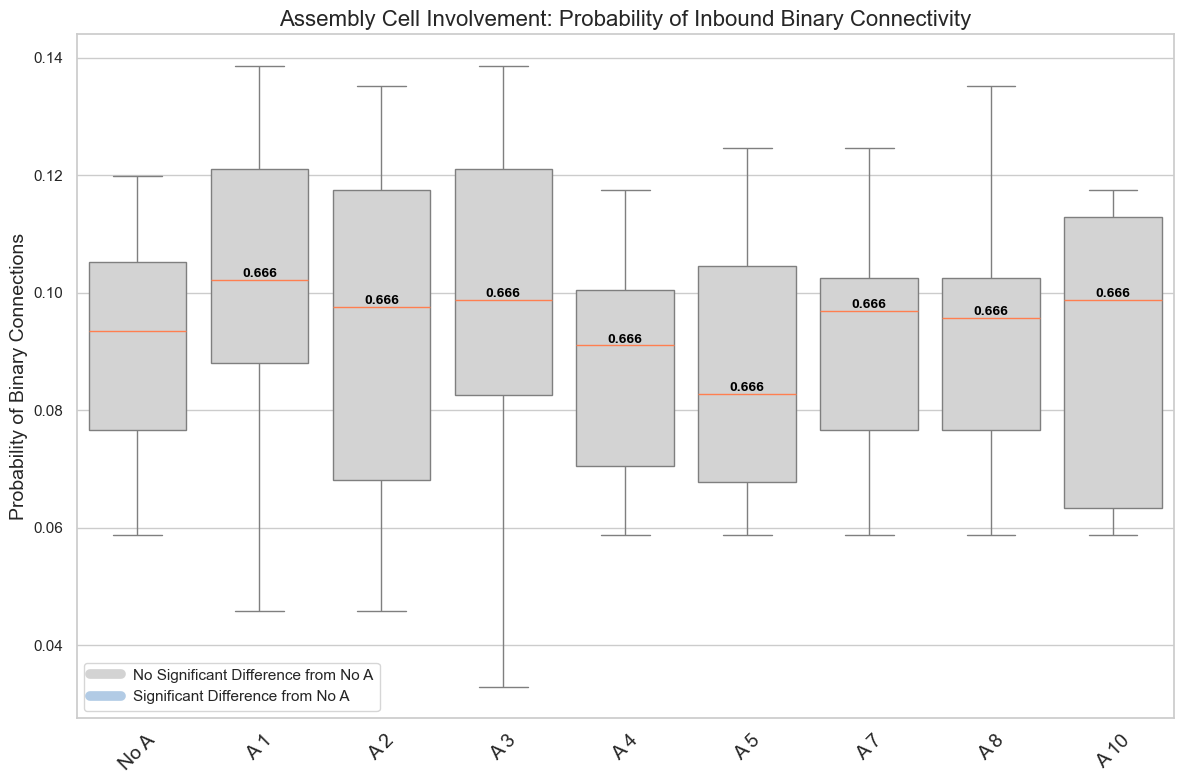

In [17]:
## Produce Inbound First-Order Connections Plot with Normalization
produce_first_order_connections_plot(input_connections_dict = inbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

[       nan 0.13077784 0.33490768 0.62918298 0.16131427 0.43868528
 0.43868528 0.15793724 0.70091927]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


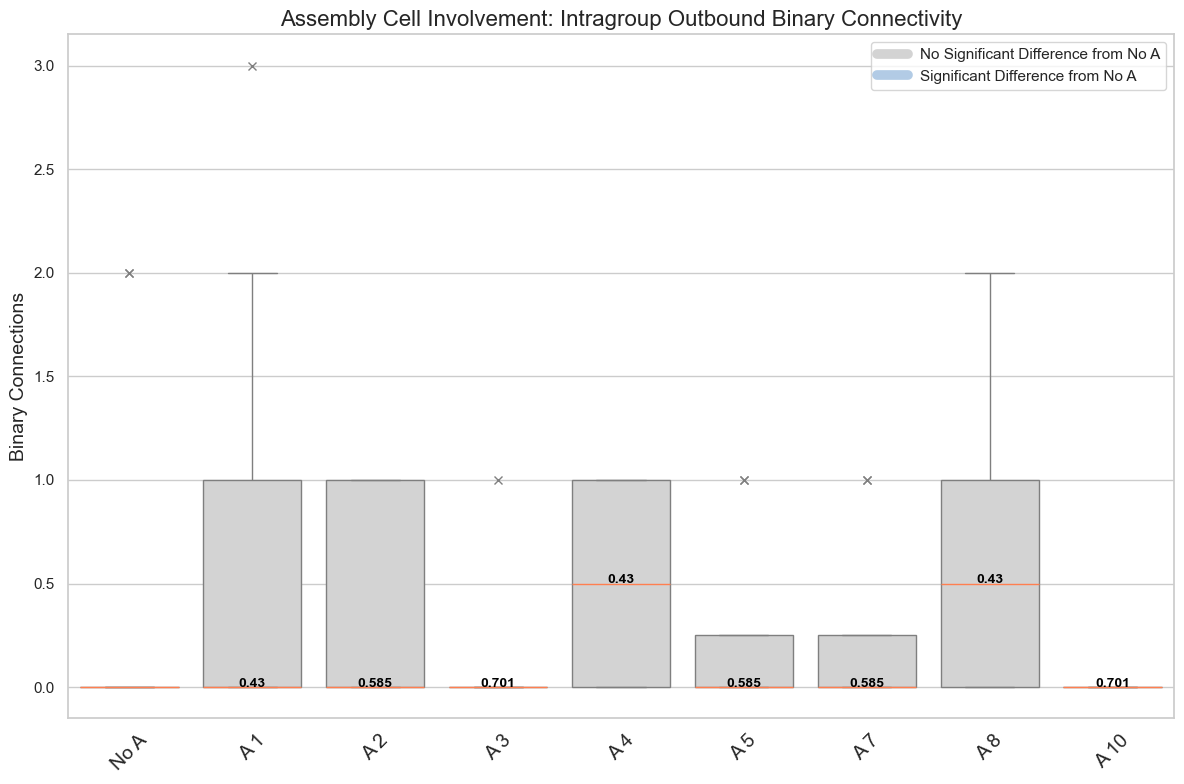

In [18]:
produce_first_order_connections_plot(input_connections_dict = outbound_binary_intragroup_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = True,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
[       nan 0.18454548 0.33490768 0.62918298 0.16131427 0.43868528
 0.43868528 0.14004361 0.70091927]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


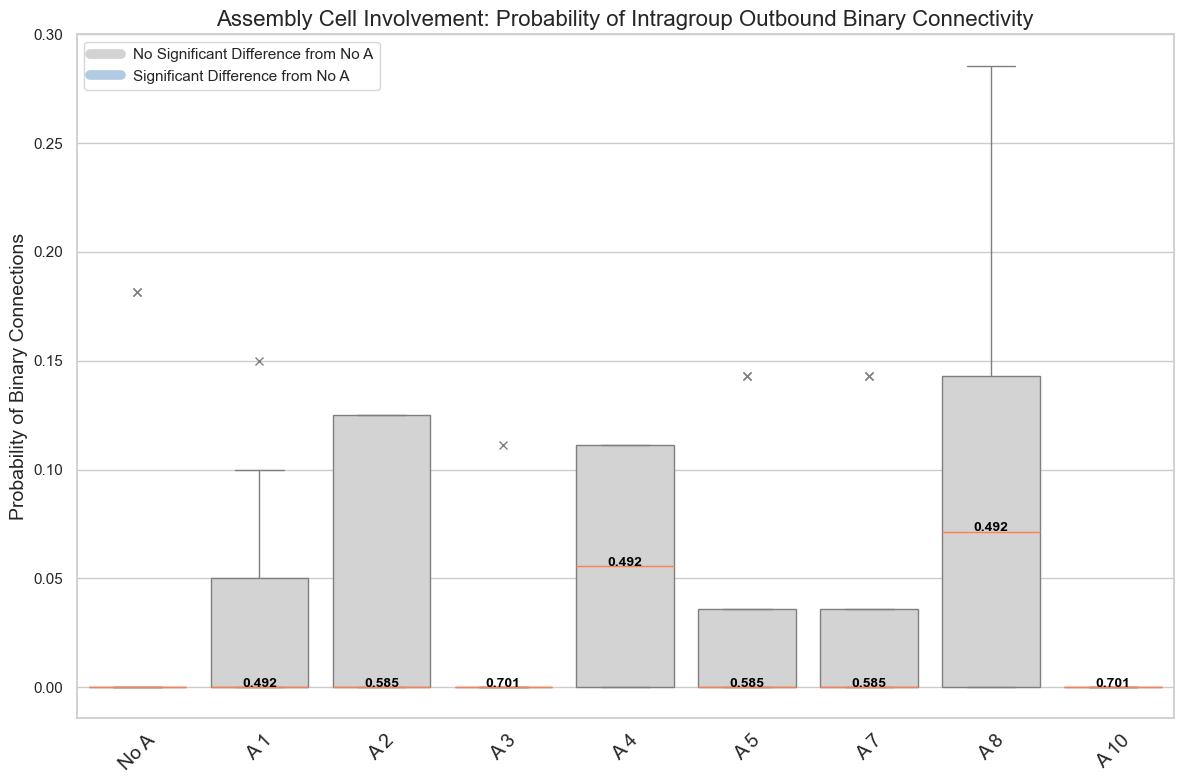

In [19]:
produce_first_order_connections_plot(input_connections_dict = outbound_binary_intragroup_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

[       nan 0.22708498 0.52832775 0.73447745 0.20490569 0.53074856
 0.65016219 0.28141688 0.78540235]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


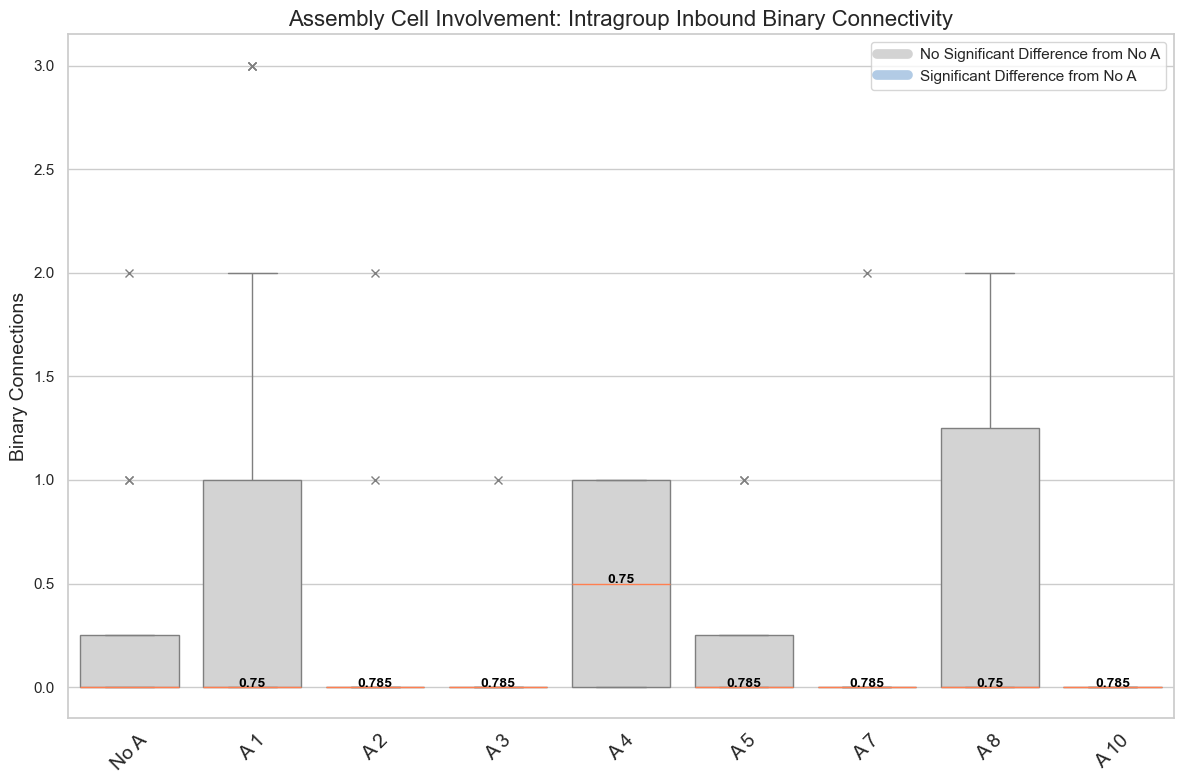

In [20]:
produce_first_order_connections_plot(input_connections_dict = inbound_binary_intragroup_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = True,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
Producing Probability of Connections with count of cells in group
[       nan 0.31996354 0.48582719 0.71242171 0.12426734 0.46925144
 0.63577291 0.23179723 0.78540235]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


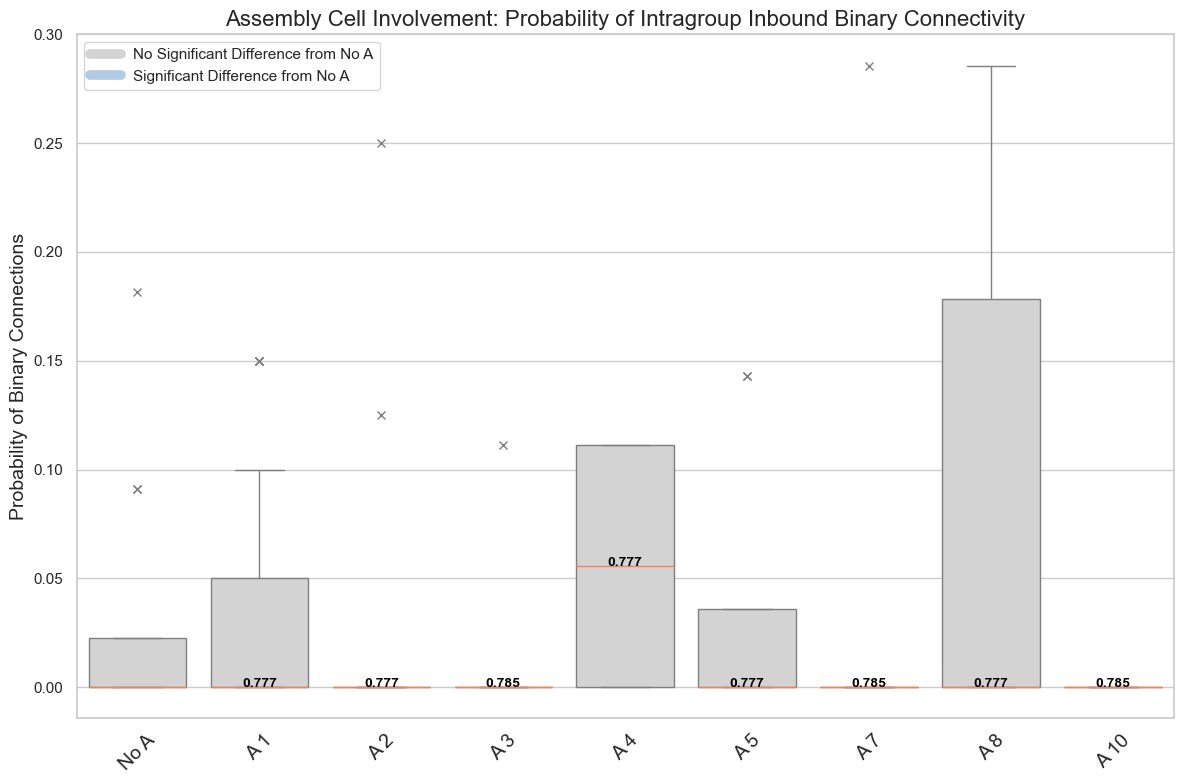

In [21]:
produce_first_order_connections_plot(input_connections_dict = inbound_binary_intragroup_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


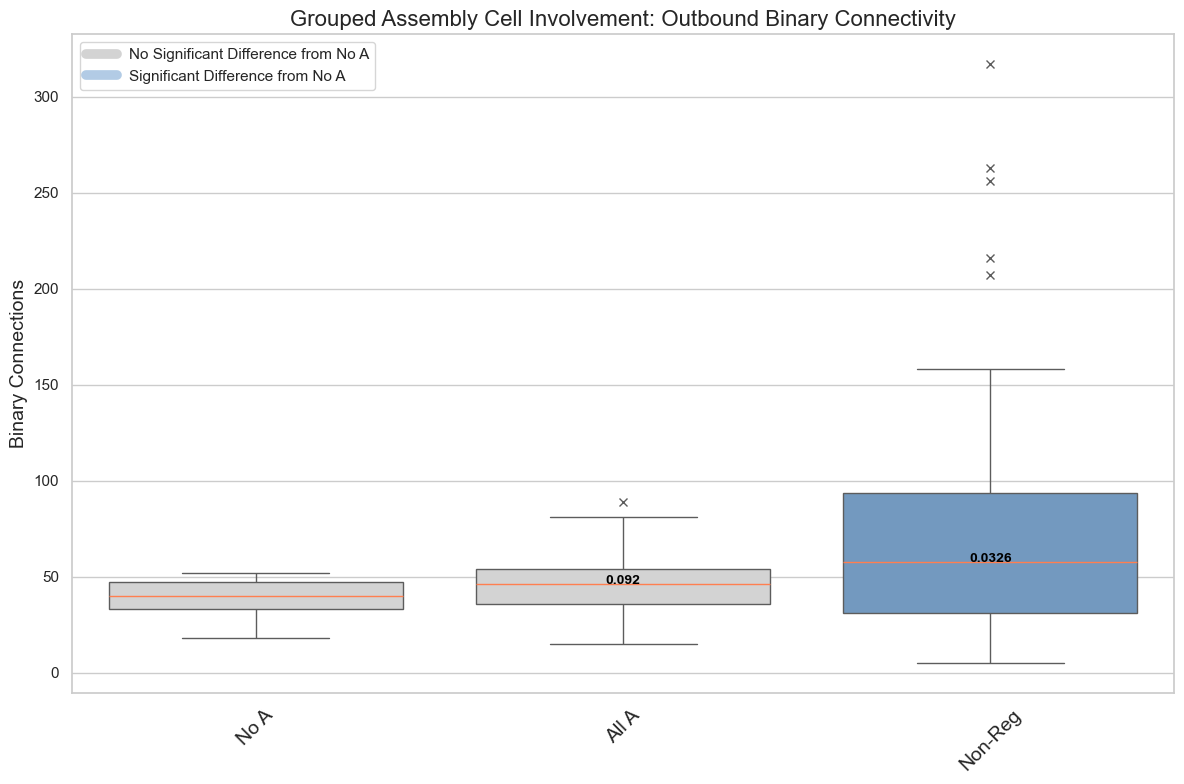

In [22]:
## Produce Grouped Outbound First-Order Connections Plot
produce_first_order_connections_plot(input_connections_dict = grouped_outbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True,
                                     include_non_registered = True)

Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


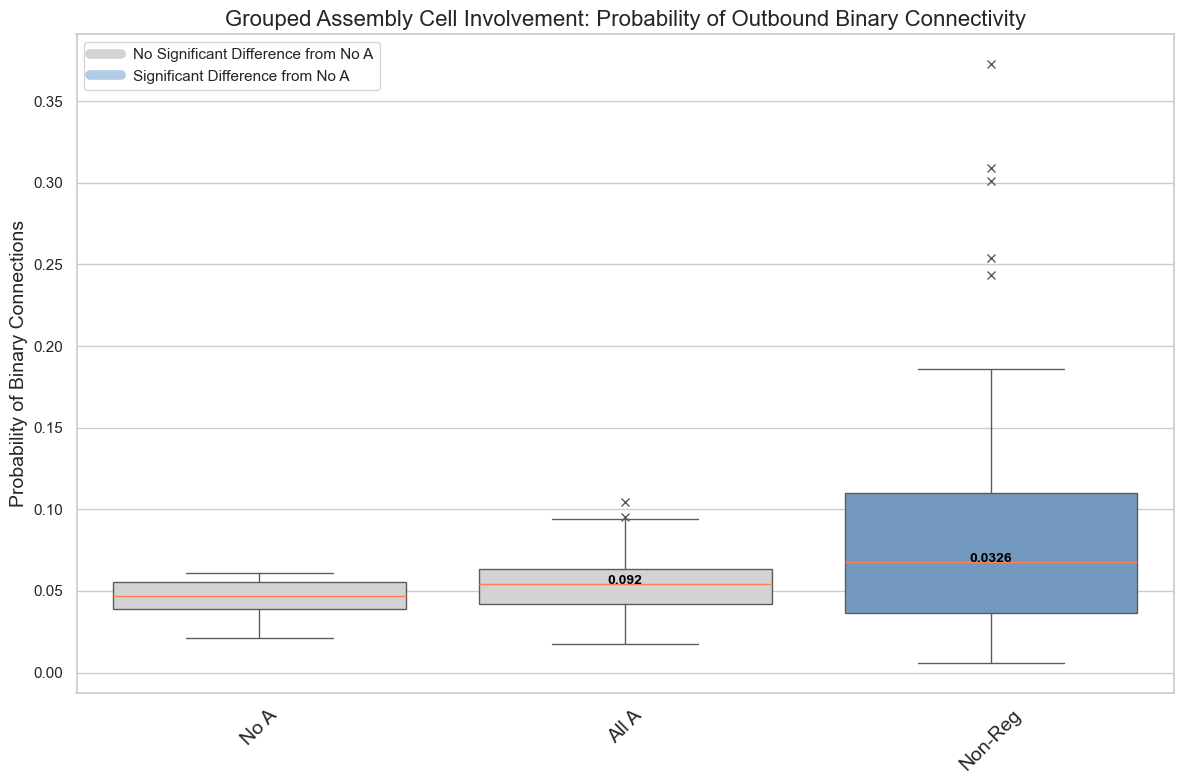

In [23]:
## Produce Grouped Outbound First-Order Connections Plot with Normalization
produce_first_order_connections_plot(input_connections_dict = grouped_outbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True,
                                     include_non_registered = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


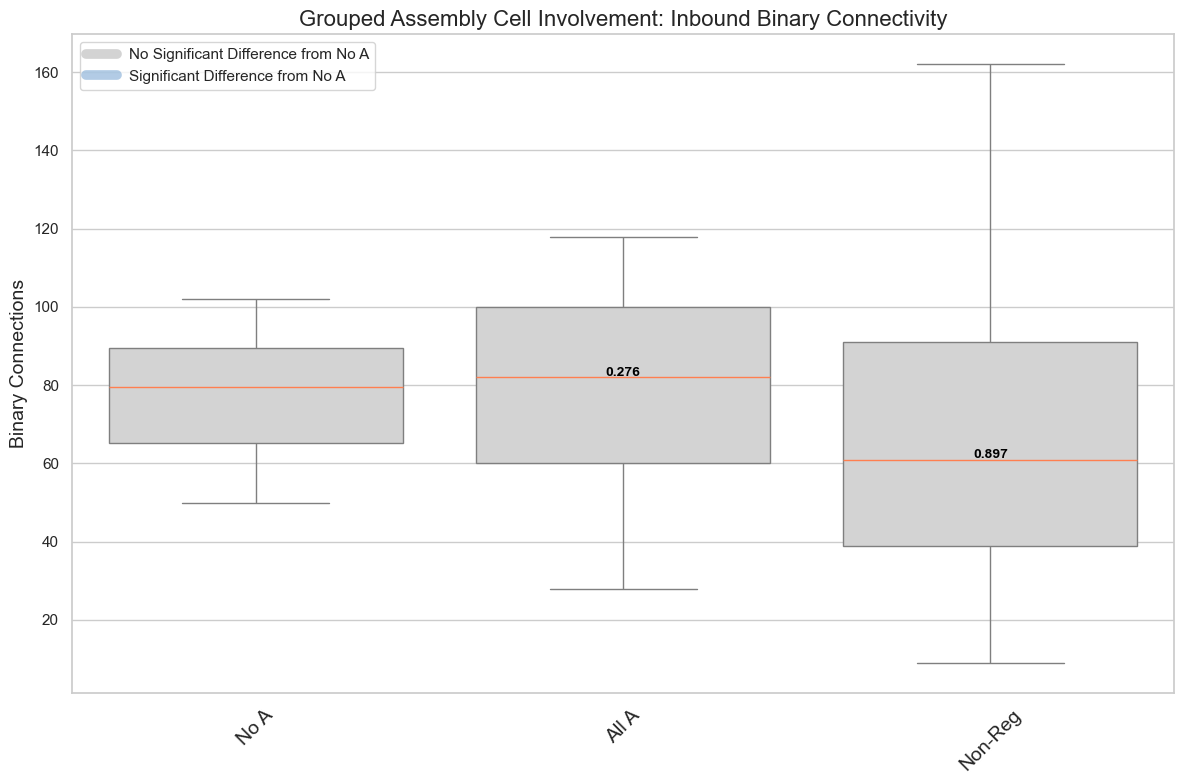

In [24]:
## Produce Grouped Outbound First-Order Connections Plot with Normalization
produce_first_order_connections_plot(input_connections_dict = grouped_inbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True,
                                     include_non_registered = True)

Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


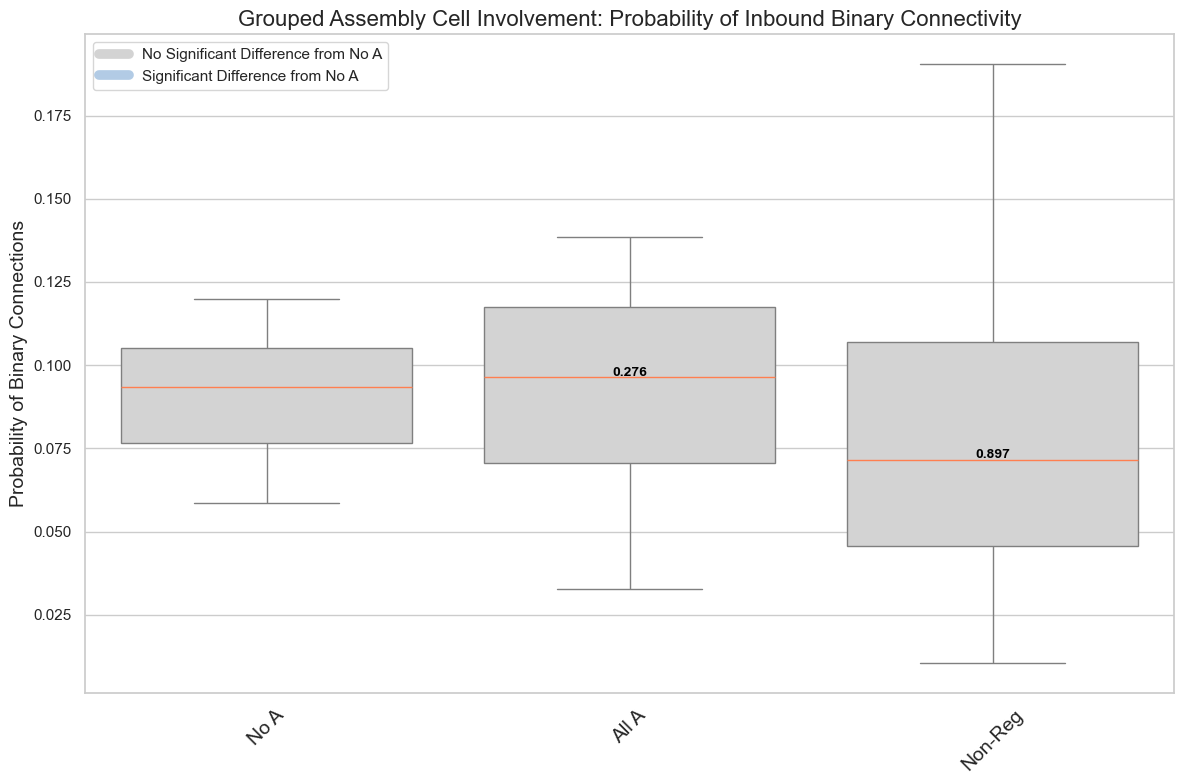

In [25]:
## Produce Grouped Outbound First-Order Connections Plot with Normalization
produce_first_order_connections_plot(input_connections_dict = grouped_inbound_binary_first_order_connections, 
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True,
                                     include_non_registered = True)

Probability Already Normalized.
Probability Already Normalized.
Probability Already Normalized.


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


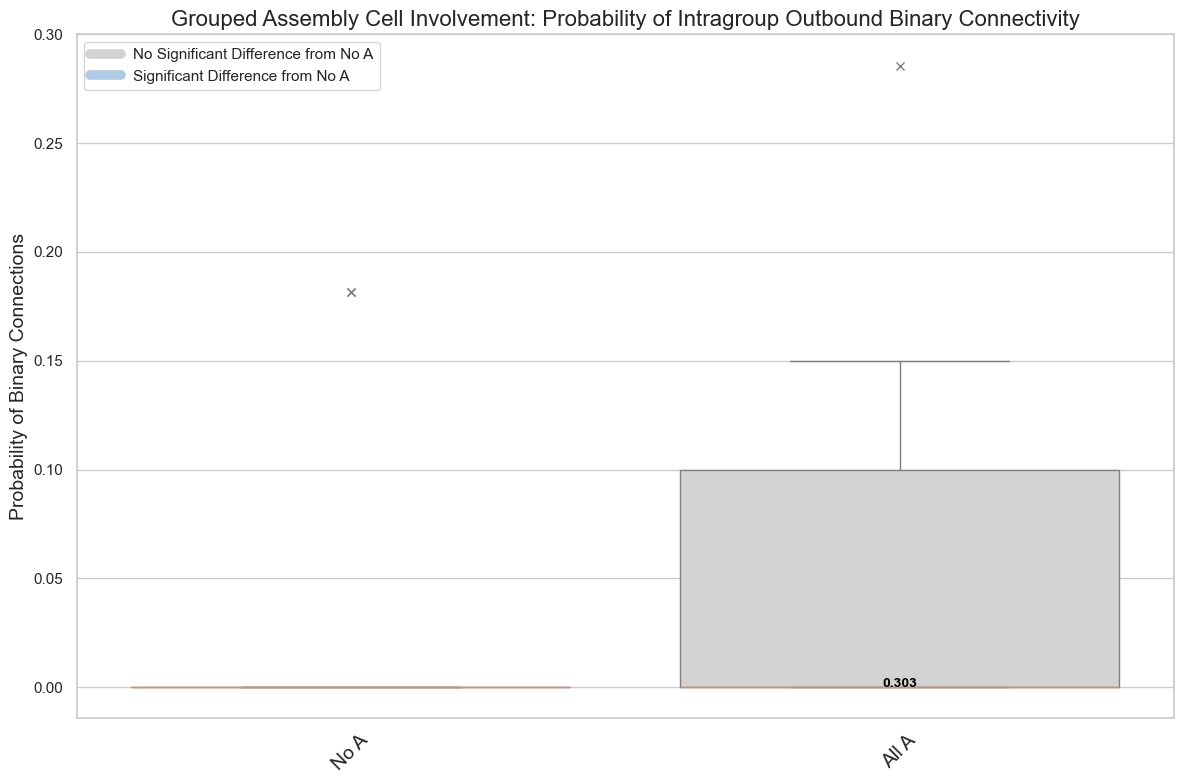

In [26]:
## Produce Grouped Outbound Intragroup First-Order Connections Plot
produce_first_order_connections_plot(input_connections_dict = grouped_intragroup_outbound_binary_first_order_connections,
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

Probability Already Normalized.
Probability Already Normalized.
Probability Already Normalized.


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


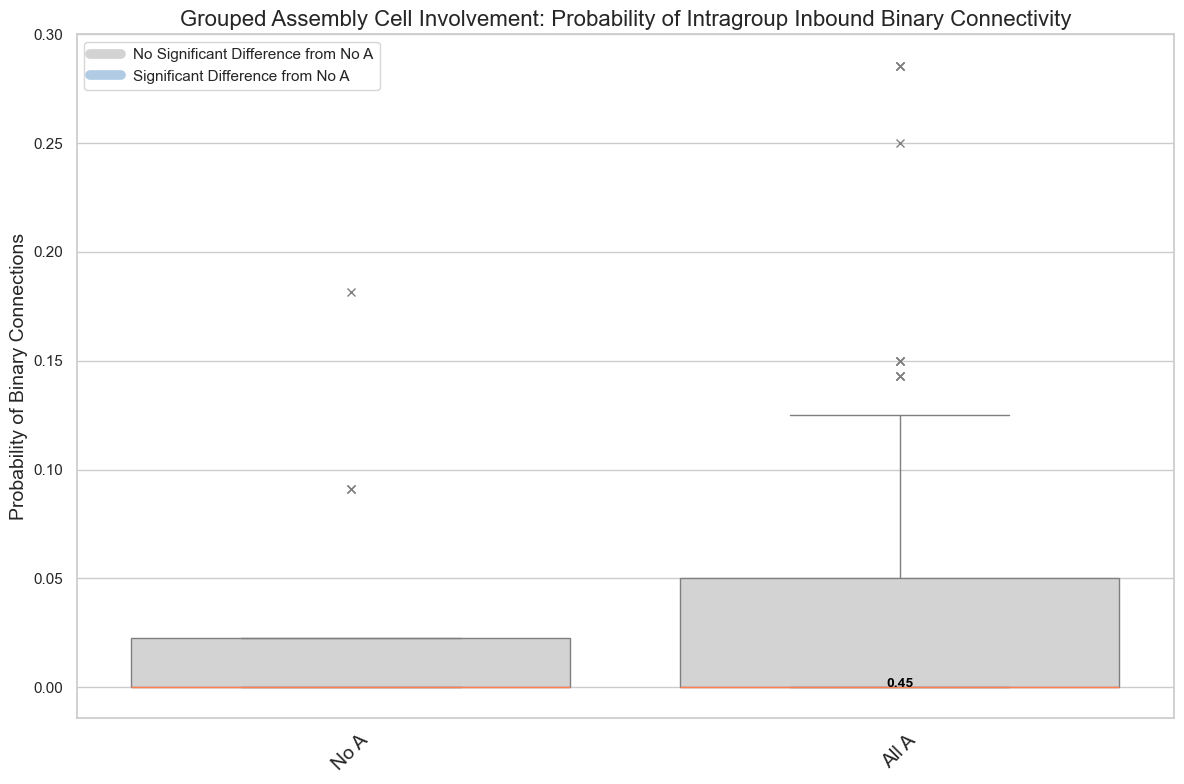

In [27]:
## Produce Grouped Inbound Intragroup First-Order Connections Plot
produce_first_order_connections_plot(input_connections_dict = grouped_intragroup_inbound_binary_first_order_connections,
                                     total_cells = binary_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = True,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

### First-Order Analyss with Synapse Count Connectome

In [28]:
# Produce Counts for Inbound and Outbound Connections
outbound_syncount_first_order_connections = {}
inbound_syncount_first_order_connections = {}
outbound_syncount_intragroup_first_order_connections = {}
inbound_syncount_intragroup_first_order_connections = {}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        outbound_syncount_first_order_connections[A] = []
        inbound_syncount_first_order_connections[A] = []
        outbound_syncount_intragroup_first_order_connections[A] = []
        inbound_syncount_intragroup_first_order_connections[A] = []
        for connectome_id in assemblies_by_coregistered[A]:
            outbound_syncount_first_order_connections[A].append(np.sum(synapse_count_connectome[connectome_id,:]))
            inbound_syncount_first_order_connections[A].append(np.sum(synapse_count_connectome[:,connectome_id]))
            outbound_syncount_intragroup_first_order_connections[A].append(np.sum(synapse_count_connectome[connectome_id,assemblies_by_coregistered[A]]))
            inbound_syncount_intragroup_first_order_connections[A].append(np.sum(synapse_count_connectome[assemblies_by_coregistered[A], connectome_id]))

print("Outbound SynCount: ", outbound_syncount_first_order_connections)
print("Inbound SynCount: ", inbound_syncount_first_order_connections)
print("Outbound SynCount Intragroup: ", outbound_syncount_intragroup_first_order_connections)
print("Inbound SynCount Intragroup: ", inbound_syncount_intragroup_first_order_connections)

Outbound SynCount:  {'A 1': [115.0, 60.0, 60.0, 84.0, 37.0, 160.0, 72.0, 77.0, 117.0, 86.0, 41.0, 49.0, 44.0, 25.0, 79.0, 70.0, 58.0, 46.0, 69.0, 71.0, 59.0], 'A 3': [60.0, 37.0, 86.0, 49.0, 44.0, 46.0, 59.0, 44.0, 54.0, 40.0], 'A 4': [60.0, 72.0, 77.0, 70.0, 46.0, 66.0, 149.0, 54.0, 54.0, 91.0], 'A 5': [60.0, 84.0, 49.0, 66.0, 54.0, 91.0, 50.0, 42.0], 'A 7': [60.0, 84.0, 72.0, 77.0, 54.0, 54.0, 91.0, 50.0], 'A 8': [60.0, 72.0, 77.0, 117.0, 59.0, 54.0, 54.0, 91.0], 'A 10': [84.0, 67.0, 87.0, 70.0, 82.0], 'A 2': [117.0, 44.0, 69.0, 40.0, 49.0, 53.0, 67.0, 66.0, 87.0], 'No A': [28.0, 80.0, 46.0, 61.0, 60.0, 56.0, 69.0, 50.0, 47.0, 30.0, 71.0, 44.0]}
Inbound SynCount:  {'A 1': [311.0, 85.0, 241.0, 187.0, 272.0, 226.0, 185.0, 184.0, 276.0, 254.0, 189.0, 259.0, 264.0, 154.0, 154.0, 180.0, 208.0, 169.0, 64.0, 130.0, 196.0], 'A 3': [85.0, 272.0, 254.0, 259.0, 264.0, 169.0, 196.0, 200.0, 134.0, 66.0], 'A 4': [85.0, 185.0, 184.0, 180.0, 169.0, 122.0, 280.0, 182.0, 210.0, 107.0], 'A 5': [85.0, 1

In [29]:
# Produce Grouped Counts for Inbound and Outbound Connections
grouped_outbound_syncount_first_order_connections = {'No A': [], "All A": [], "Non-Reg": []}
grouped_inbound_syncount_first_order_connections = {'No A': [], "All A": [], "Non-Reg": []}
grouped_intragroup_outbound_syncount_first_order_connections = {'No A': [], "All A": [], "Non-Reg": []}
grouped_intragroup_inbound_syncount_first_order_connections = {'No A': [], "All A": [], "Non-Reg": []}

non_intragroup_assembly_indexes = set()
for A, group_indexes in assemblies_by_coregistered.items():
    if len(group_indexes) < 2:
        continue
    
    for c_index in group_indexes:
        outbound_sum = np.sum(synapse_count_connectome[c_index,:])
        inbound_sum = np.sum(synapse_count_connectome[:,c_index])
        # Will normalize already by all possible connections in group
        intragroup_outbound_sum = np.sum(synapse_count_connectome[c_index,group_indexes]) / (len(group_indexes) - 1)
        intragroup_inbound_sum = np.sum(synapse_count_connectome[group_indexes,c_index]) / (len(group_indexes) - 1)
        if A == 'No A':
            grouped_outbound_syncount_first_order_connections['No A'].append(outbound_sum)
            grouped_inbound_syncount_first_order_connections['No A'].append(inbound_sum)
            grouped_intragroup_outbound_syncount_first_order_connections['No A'].append(intragroup_outbound_sum)
            grouped_intragroup_inbound_syncount_first_order_connections['No A'].append(intragroup_inbound_sum)
        else:
            grouped_intragroup_outbound_syncount_first_order_connections['All A'].append(intragroup_outbound_sum)
            grouped_intragroup_inbound_syncount_first_order_connections['All A'].append(intragroup_inbound_sum)
            # Make sure there is no double counting in non-intragroup analysis
            if c_index not in non_intragroup_assembly_indexes:
                grouped_outbound_syncount_first_order_connections['All A'].append(outbound_sum)
                grouped_inbound_syncount_first_order_connections['All A'].append(inbound_sum)
                non_intragroup_assembly_indexes.add(c_index)

# Add Analysis for non-registered ids
for c_index in non_registered_ids:
    outbound_sum = np.sum(synapse_count_connectome[c_index,:])
    inbound_sum = np.sum(synapse_count_connectome[:,c_index])
    grouped_outbound_syncount_first_order_connections['Non-Reg'].append(outbound_sum)
    grouped_inbound_syncount_first_order_connections['Non-Reg'].append(inbound_sum)

print("Grouped Outbound SynCount: ", grouped_outbound_syncount_first_order_connections)
print("Grouped Inbound SynCount: ", grouped_inbound_syncount_first_order_connections)
print("Grouped Outbound SynCount Intragroup: ", grouped_intragroup_outbound_syncount_first_order_connections)
print("Grouped Inbound SynCount Intragroup: ", grouped_intragroup_inbound_syncount_first_order_connections)

Grouped Outbound SynCount:  {'No A': [28.0, 80.0, 46.0, 61.0, 60.0, 56.0, 69.0, 50.0, 47.0, 30.0, 71.0, 44.0], 'All A': [115.0, 60.0, 60.0, 84.0, 37.0, 160.0, 72.0, 77.0, 117.0, 86.0, 41.0, 49.0, 44.0, 25.0, 79.0, 70.0, 58.0, 46.0, 69.0, 71.0, 59.0, 44.0, 54.0, 40.0, 66.0, 149.0, 54.0, 54.0, 91.0, 50.0, 42.0, 67.0, 87.0, 70.0, 82.0, 40.0, 49.0, 53.0, 72.0, 103.0, 40.0], 'Non-Reg': [102.0, 239.0, 53.0, 218.0, 35.0, 7.0, 40.0, 135.0, 221.0, 104.0, 73.0, 711.0, 290.0, 558.0, 222.0, 66.0, 43.0, 266.0, 8.0, 104.0, 83.0, 21.0, 63.0, 65.0, 6.0, 672.0, 170.0, 57.0, 17.0, 72.0, 234.0, 155.0, 883.0, 51.0, 104.0, 33.0, 716.0, 672.0, 269.0, 49.0, 11.0, 126.0, 17.0, 78.0, 50.0, 52.0, 126.0, 104.0, 63.0, 45.0]}
Grouped Inbound SynCount:  {'No A': [196.0, 247.0, 162.0, 235.0, 166.0, 244.0, 160.0, 113.0, 231.0, 114.0, 136.0, 180.0], 'All A': [311.0, 85.0, 241.0, 187.0, 272.0, 226.0, 185.0, 184.0, 276.0, 254.0, 189.0, 259.0, 264.0, 154.0, 154.0, 180.0, 208.0, 169.0, 64.0, 130.0, 196.0, 200.0, 134.0, 66

Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
[       nan 0.06246731 0.17777706 0.74517426 0.03242684 0.19803291
 0.03799119 0.02936454 0.004204  ]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


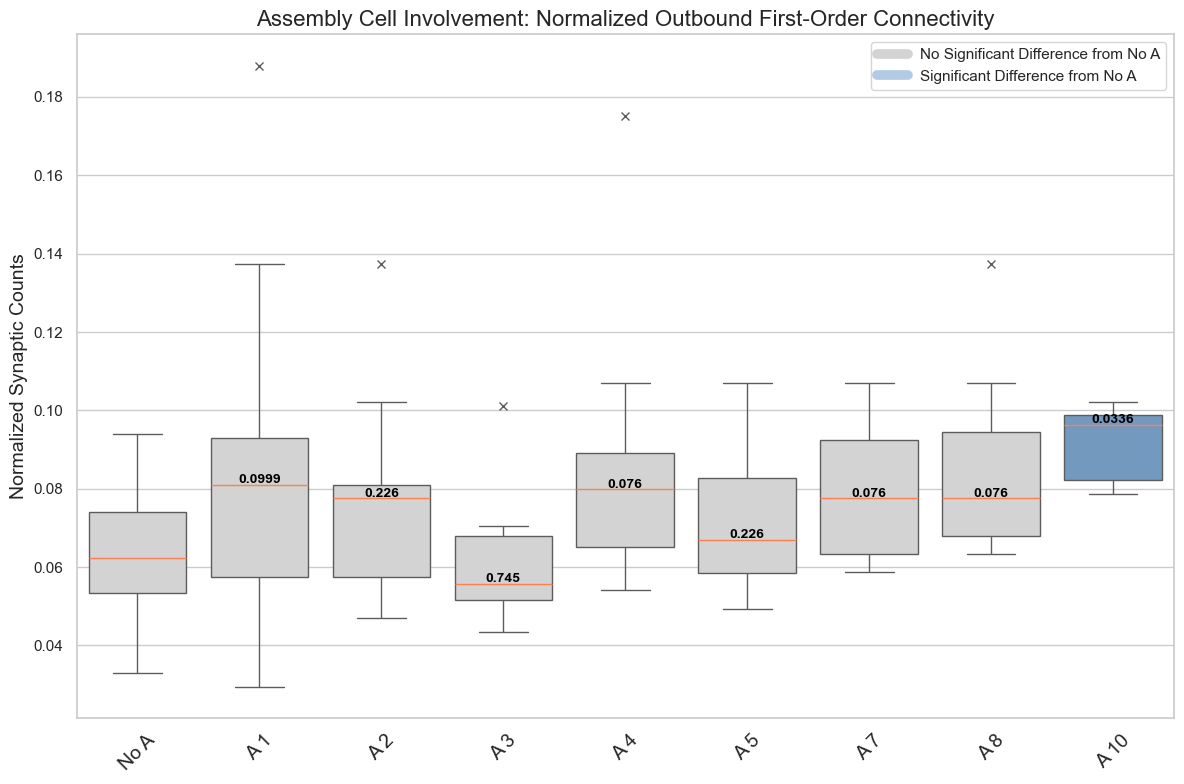

In [30]:
produce_first_order_connections_plot(input_connections_dict = outbound_syncount_first_order_connections, 
                                     total_cells = synapse_count_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
[       nan 0.14734841 0.28483579 0.22413943 0.61666032 0.73145301
 0.75627335 0.63577291 0.45802554]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


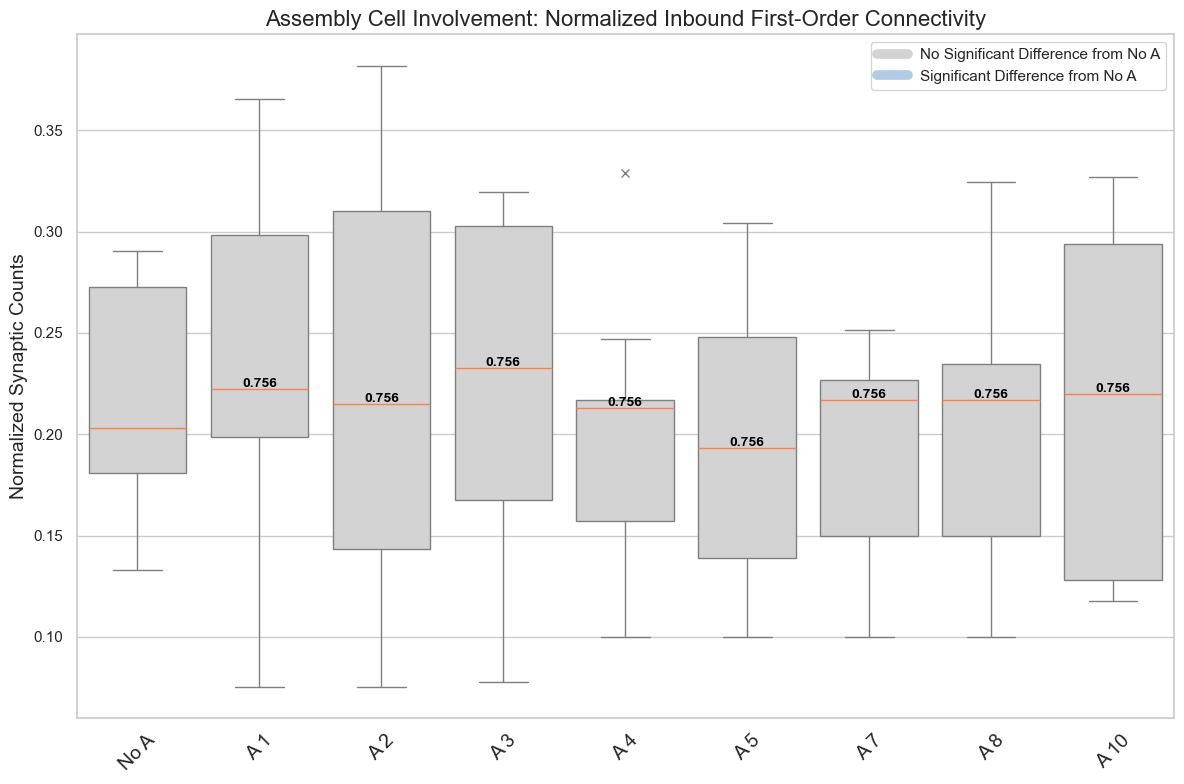

In [31]:
produce_first_order_connections_plot(input_connections_dict = inbound_syncount_first_order_connections, 
                                     total_cells = synapse_count_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


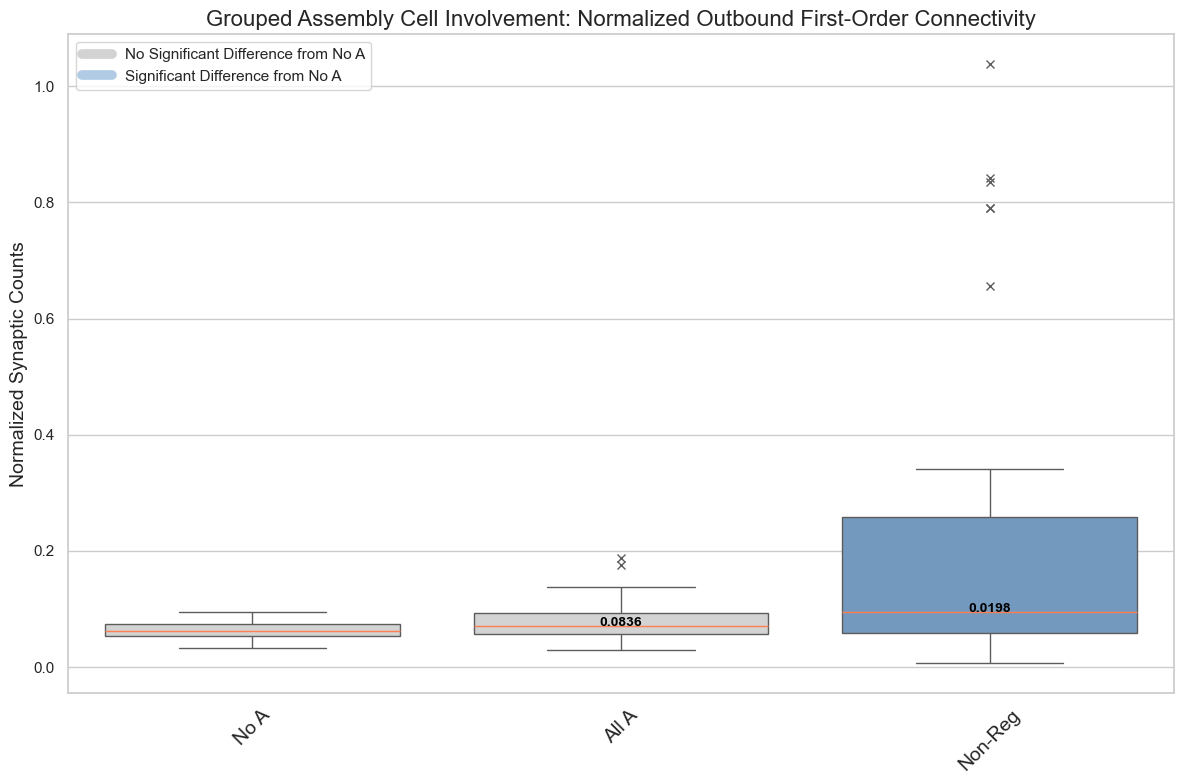

In [32]:
produce_first_order_connections_plot(input_connections_dict = grouped_outbound_syncount_first_order_connections, 
                                     total_cells = synapse_count_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True,
                                     include_non_registered = True)

Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852
Producing Probability of Connections with total cell count: 852


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


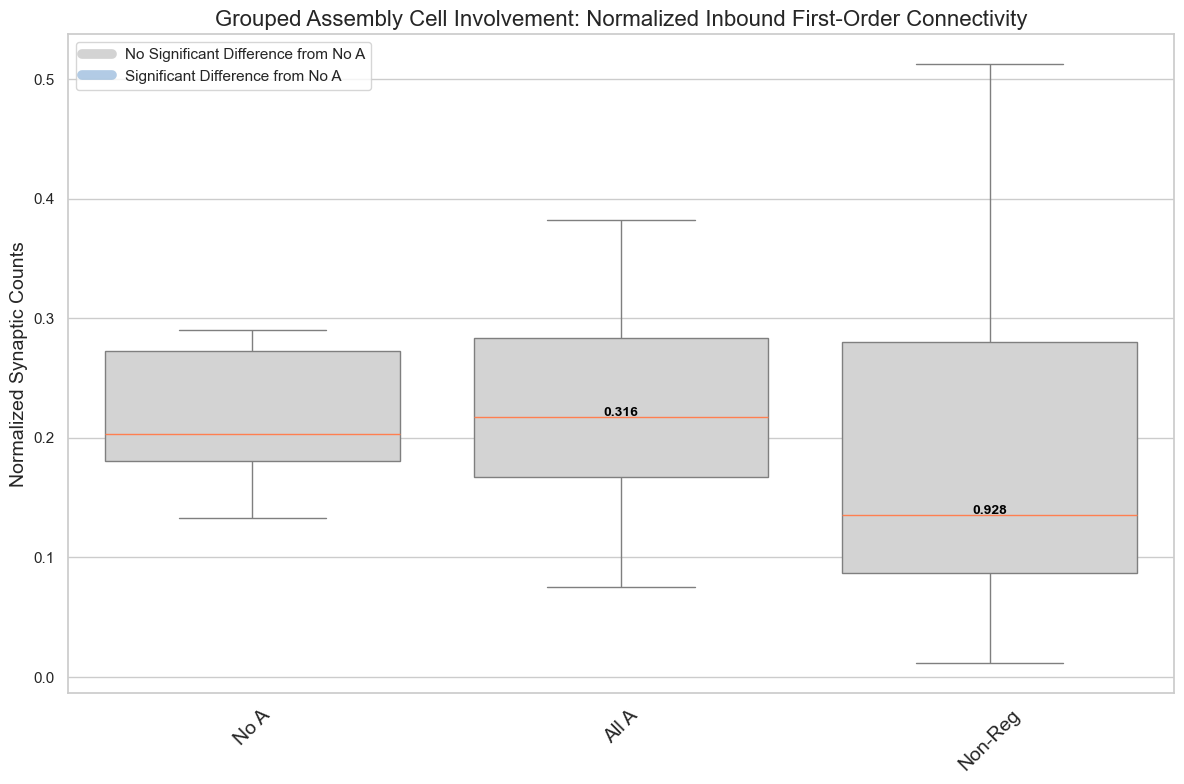

In [33]:
produce_first_order_connections_plot(input_connections_dict = grouped_inbound_syncount_first_order_connections, 
                                     total_cells = synapse_count_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True,
                                     include_non_registered = True)

Probability Already Normalized.
Probability Already Normalized.
Probability Already Normalized.


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


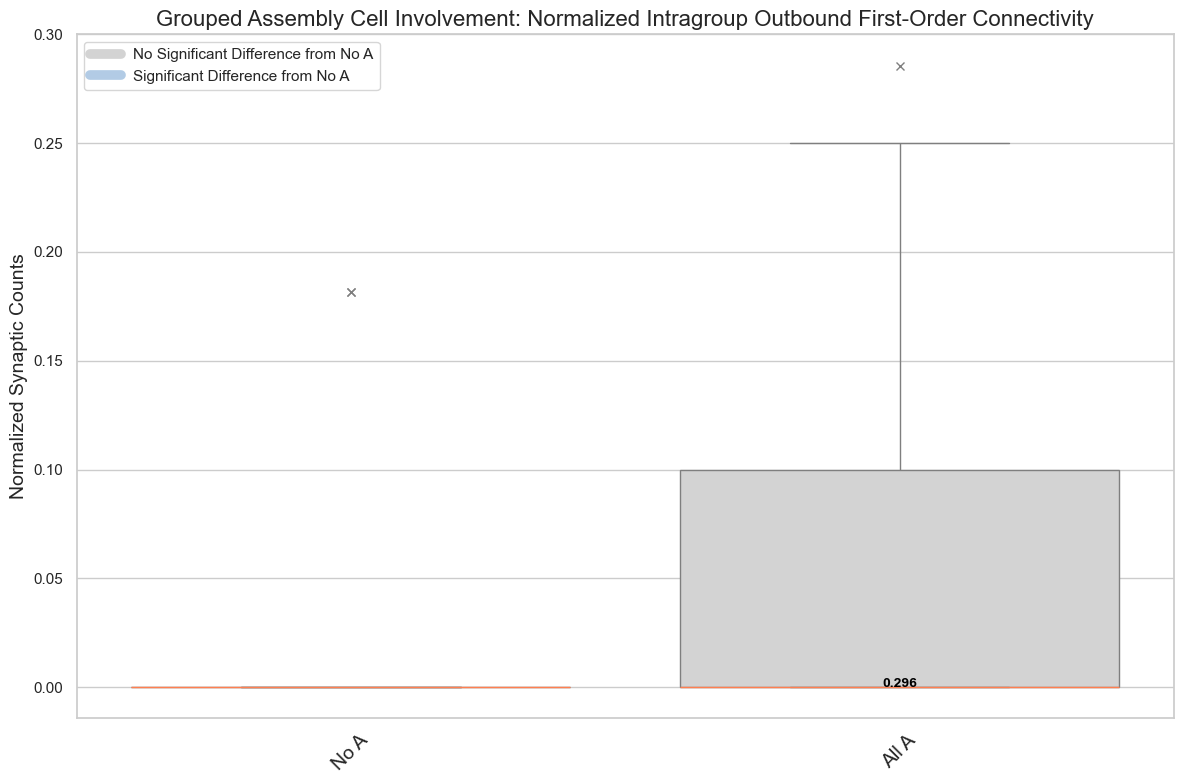

In [34]:
produce_first_order_connections_plot(input_connections_dict = grouped_intragroup_outbound_syncount_first_order_connections, 
                                     total_cells = synapse_count_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

Probability Already Normalized.
Probability Already Normalized.
Probability Already Normalized.


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


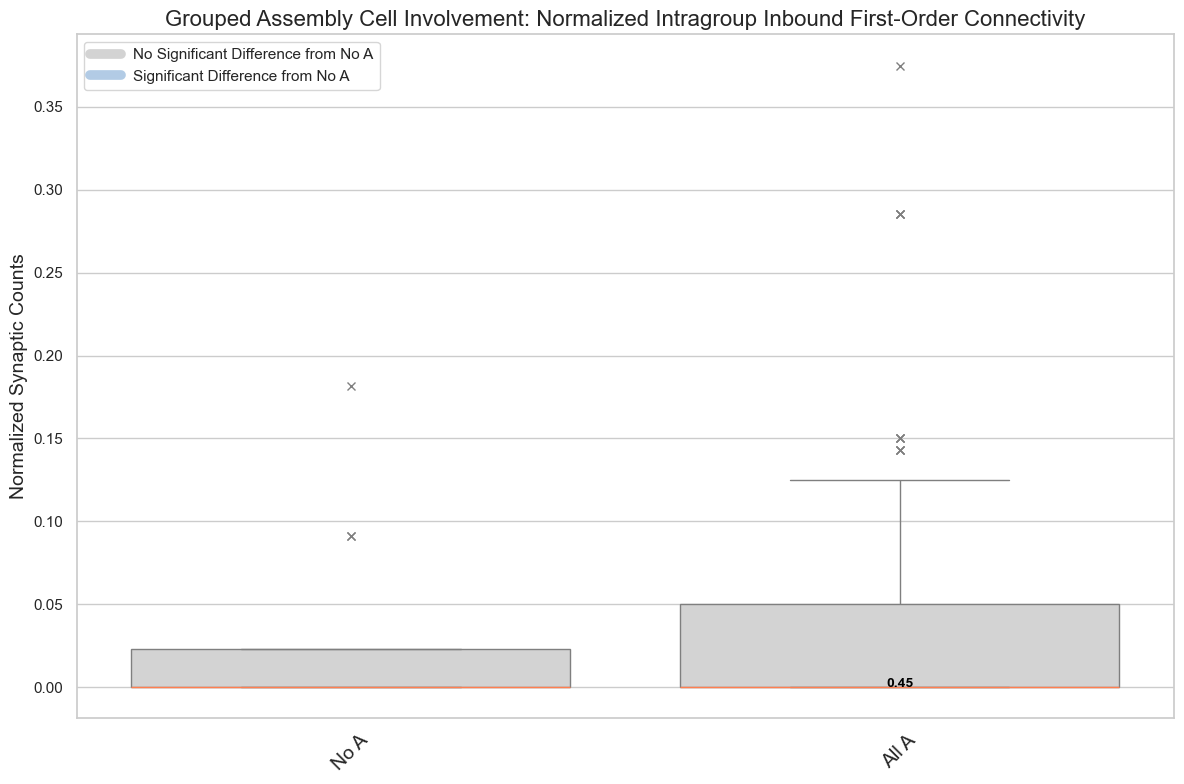

In [35]:
produce_first_order_connections_plot(input_connections_dict = grouped_intragroup_inbound_syncount_first_order_connections, 
                                     total_cells = synapse_count_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = True, 
                                     summed_psd = False,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

### First-Order Analysis with Summed PSD Connectome

In [36]:
# Produce Counts for Inbound and Outbound Connections
outbound_summed_psd_first_order_connections = {}
inbound_summed_psd_first_order_connections = {}
outbound_summed_psd_intragroup_first_order_connections = {}
inbound_summed_psd_intragroup_first_order_connections = {}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        outbound_summed_psd_first_order_connections[A] = []
        inbound_summed_psd_first_order_connections[A] = []
        outbound_summed_psd_intragroup_first_order_connections[A] = []
        inbound_summed_psd_intragroup_first_order_connections[A] = []
        for connectome_id in assemblies_by_coregistered[A]:
            outbound_summed_psd_first_order_connections[A].append(np.sum(summed_size_connectome[connectome_id,:]))
            inbound_summed_psd_first_order_connections[A].append(np.sum(summed_size_connectome[:,connectome_id]))
            outbound_summed_psd_intragroup_first_order_connections[A].append(np.sum(summed_size_connectome[connectome_id,assemblies_by_coregistered[A]]))
            inbound_summed_psd_intragroup_first_order_connections[A].append(np.sum(summed_size_connectome[assemblies_by_coregistered[A], connectome_id]))

print("Outbound Summed PSD: ", outbound_summed_psd_first_order_connections)
print("Inbound Summed PSD: ", inbound_summed_psd_first_order_connections)
print("Outbound Summed PSD Intragroup: ", outbound_summed_psd_intragroup_first_order_connections)
print("Inbound Summed PSD Intragroup: ", inbound_summed_psd_intragroup_first_order_connections)

Outbound Summed PSD:  {'A 1': [174644.0, 87355.0, 92140.0, 95109.0, 47822.0, 192969.0, 109017.0, 103039.0, 144389.0, 129688.0, 54196.0, 81552.0, 47315.0, 27646.0, 100727.0, 90800.0, 86146.0, 65473.0, 99645.0, 101202.0, 71236.0], 'A 3': [87355.0, 47822.0, 129688.0, 81552.0, 47315.0, 65473.0, 71236.0, 65905.0, 73678.0, 45733.0], 'A 4': [87355.0, 109017.0, 103039.0, 90800.0, 65473.0, 88445.0, 210403.0, 82771.0, 64682.0, 118523.0], 'A 5': [87355.0, 95109.0, 81552.0, 88445.0, 64682.0, 118523.0, 72878.0, 67804.0], 'A 7': [87355.0, 95109.0, 109017.0, 103039.0, 73678.0, 64682.0, 118523.0, 72878.0], 'A 8': [87355.0, 109017.0, 103039.0, 144389.0, 71236.0, 73678.0, 64682.0, 118523.0], 'A 10': [95109.0, 99885.0, 143536.0, 98479.0, 105577.0], 'A 2': [144389.0, 47315.0, 99645.0, 66185.0, 54470.0, 91577.0, 99885.0, 88445.0, 143536.0], 'No A': [30752.0, 102407.0, 59491.0, 86095.0, 85162.0, 74554.0, 92296.0, 92990.0, 57647.0, 49937.0, 89489.0, 54199.0]}
Inbound Summed PSD:  {'A 1': [257803.0, 65163.0, 

In [37]:
# Produce Grouped Counts for Inbound and Outbound Connections
grouped_outbound_summed_psd_first_order_connections = {'No A': [], "All A": [], "Non-Reg": []}
grouped_inbound_summed_psd_first_order_connections = {'No A': [], "All A": [], "Non-Reg": []}
grouped_intragroup_outbound_summed_psd_first_order_connections = {'No A': [], "All A": [], "Non-Reg": []}
grouped_intragroup_inbound_summed_psd_first_order_connections = {'No A': [], "All A": [], "Non-Reg": []}

non_intragroup_assembly_indexes = set()
for A, group_indexes in assemblies_by_coregistered.items():
    if len(group_indexes) < 2:
        continue
    
    for c_index in group_indexes:
        outbound_sum = np.sum(summed_size_connectome[c_index,:])
        inbound_sum = np.sum(summed_size_connectome[:,c_index])
        # Will normalize already by all possible connections in group
        intragroup_outbound_sum = np.sum(summed_size_connectome[c_index,group_indexes]) / (len(group_indexes) - 1)
        intragroup_inbound_sum = np.sum(summed_size_connectome[group_indexes,c_index]) / (len(group_indexes) - 1)
        if A == 'No A':
            grouped_outbound_summed_psd_first_order_connections['No A'].append(outbound_sum)
            grouped_inbound_summed_psd_first_order_connections['No A'].append(inbound_sum)
            grouped_intragroup_outbound_summed_psd_first_order_connections['No A'].append(intragroup_outbound_sum)
            grouped_intragroup_inbound_summed_psd_first_order_connections['No A'].append(intragroup_inbound_sum)
        else:
            grouped_intragroup_outbound_summed_psd_first_order_connections['All A'].append(intragroup_outbound_sum)
            grouped_intragroup_inbound_summed_psd_first_order_connections['All A'].append(intragroup_inbound_sum)
            # Make sure there is no double counting in non-intragroup analysis
            if c_index not in non_intragroup_assembly_indexes:
                grouped_outbound_summed_psd_first_order_connections['All A'].append(outbound_sum)
                grouped_inbound_summed_psd_first_order_connections['All A'].append(inbound_sum)
                non_intragroup_assembly_indexes.add(c_index)

# Add Analysis for non-registered ids
for c_index in non_registered_ids:
    outbound_sum = np.sum(summed_size_connectome[c_index,:])
    inbound_sum = np.sum(summed_size_connectome[:,c_index])
    grouped_outbound_summed_psd_first_order_connections['Non-Reg'].append(outbound_sum)
    grouped_inbound_summed_psd_first_order_connections['Non-Reg'].append(inbound_sum)

print("Grouped Outbound Summed PSD: ", grouped_outbound_summed_psd_first_order_connections)
print("Grouped Inbound Summed PSD: ", grouped_inbound_summed_psd_first_order_connections)
print("Grouped Outbound Summed PSD Intragroup: ", grouped_intragroup_outbound_summed_psd_first_order_connections)
print("Grouped Inbound Summed PSD Intragroup: ", grouped_intragroup_inbound_summed_psd_first_order_connections)

Grouped Outbound Summed PSD:  {'No A': [30752.0, 102407.0, 59491.0, 86095.0, 85162.0, 74554.0, 92296.0, 92990.0, 57647.0, 49937.0, 89489.0, 54199.0], 'All A': [174644.0, 87355.0, 92140.0, 95109.0, 47822.0, 192969.0, 109017.0, 103039.0, 144389.0, 129688.0, 54196.0, 81552.0, 47315.0, 27646.0, 100727.0, 90800.0, 86146.0, 65473.0, 99645.0, 101202.0, 71236.0, 65905.0, 73678.0, 45733.0, 88445.0, 210403.0, 82771.0, 64682.0, 118523.0, 72878.0, 67804.0, 99885.0, 143536.0, 98479.0, 105577.0, 66185.0, 54470.0, 91577.0, 86927.0, 180739.0, 52978.0], 'Non-Reg': [135167.0, 222670.0, 62759.0, 247312.0, 49798.0, 7054.0, 68372.0, 213842.0, 144600.0, 181276.0, 122083.0, 440611.0, 231043.0, 400647.0, 263408.0, 131492.0, 65054.0, 172470.0, 9605.0, 143518.0, 102429.0, 28251.0, 103592.0, 61397.0, 3424.0, 480696.0, 145347.0, 82473.0, 6152.0, 100635.0, 163325.0, 231224.0, 631842.0, 86137.0, 77686.0, 68741.0, 424764.0, 543975.0, 352366.0, 28154.0, 19922.0, 185064.0, 36253.0, 75252.0, 84432.0, 87581.0, 132947.0,

[       nan 0.04981412 0.10041256 0.76587168 0.02792506 0.17726974
 0.0448165  0.03799119 0.00221326]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


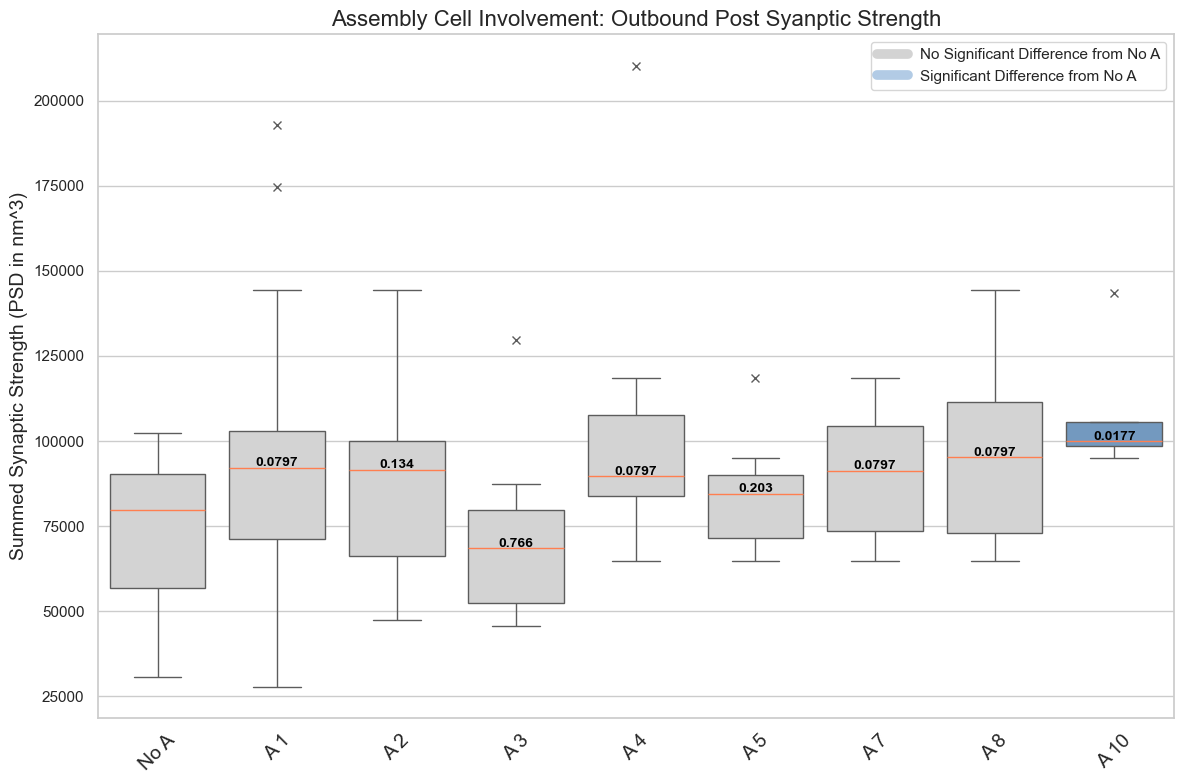

In [38]:
produce_first_order_connections_plot(input_connections_dict = outbound_summed_psd_first_order_connections, 
                                     total_cells = summed_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

[       nan 0.14734841 0.28483579 0.29892169 0.62918298 0.82273026
 0.77979965 0.67828558 0.5       ]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


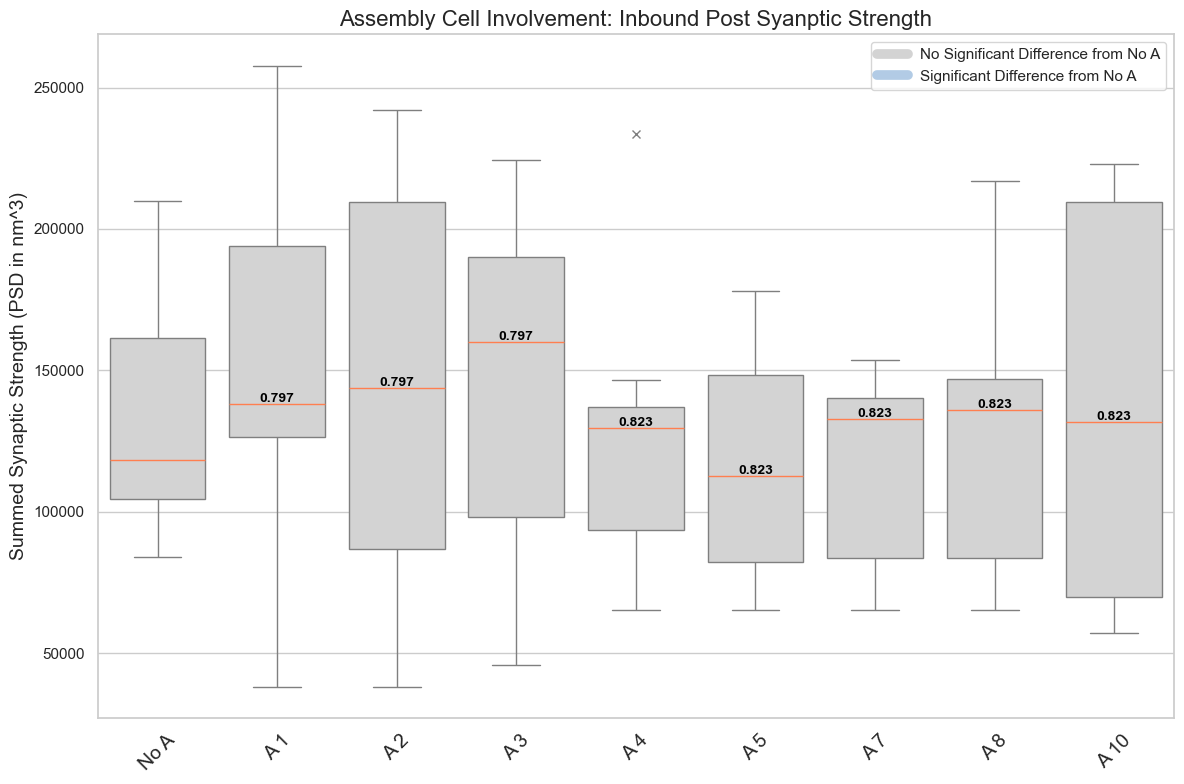

In [39]:
produce_first_order_connections_plot(input_connections_dict = inbound_summed_psd_first_order_connections, 
                                     total_cells = summed_size_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


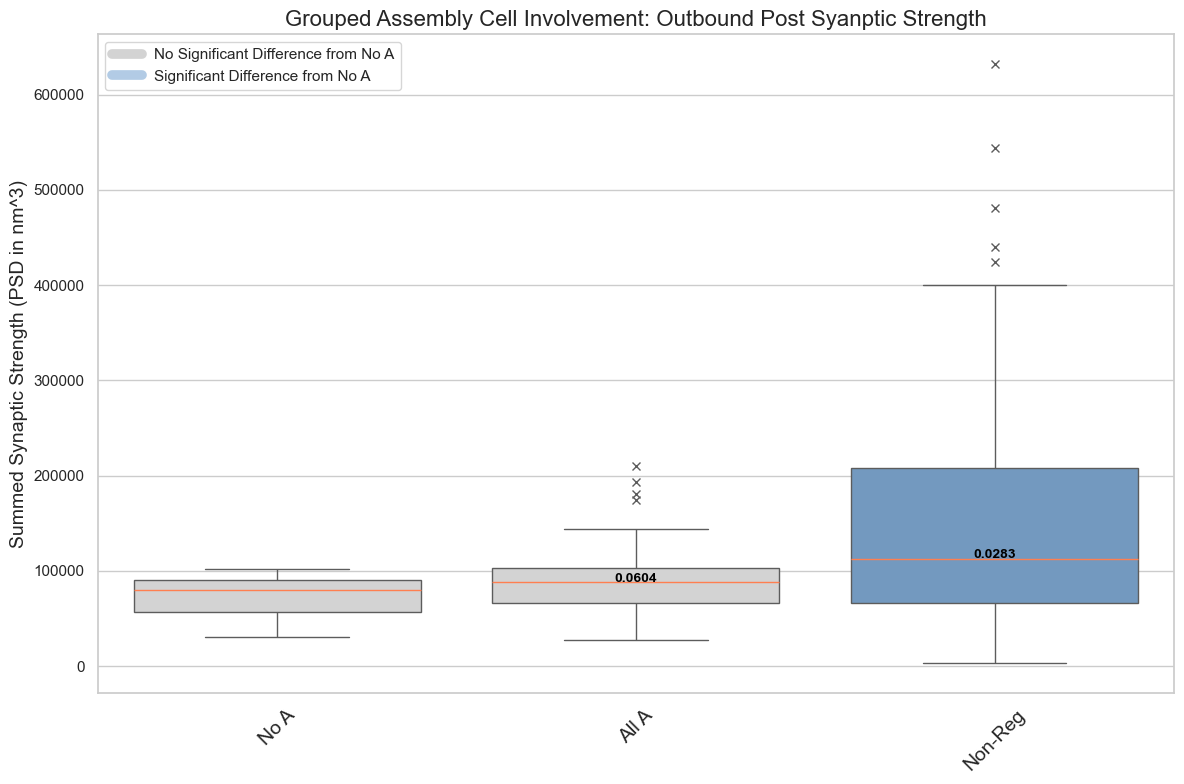

In [40]:
produce_first_order_connections_plot(input_connections_dict = grouped_outbound_summed_psd_first_order_connections, 
                                     total_cells = summed_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True,
                                     include_non_registered = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


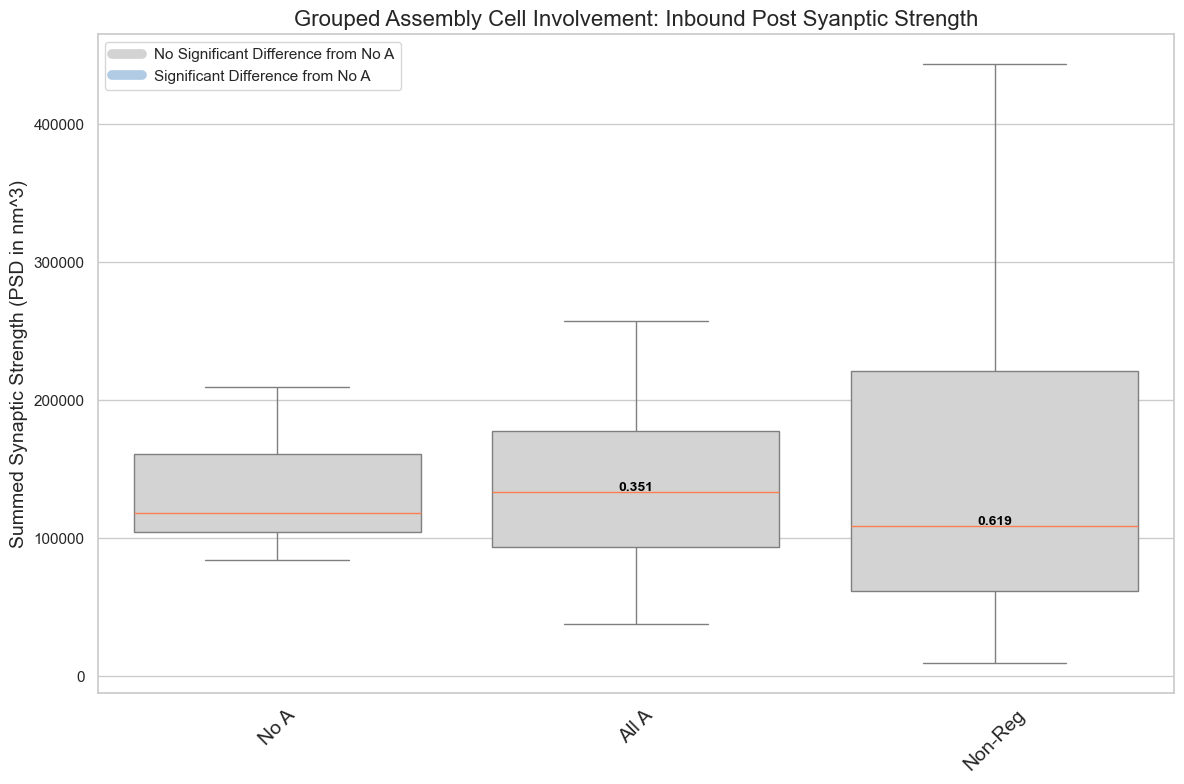

In [41]:
produce_first_order_connections_plot(input_connections_dict = grouped_inbound_summed_psd_first_order_connections, 
                                     total_cells = summed_size_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True,
                                     include_non_registered = True)

Probability Already Normalized.
Probability Already Normalized.
Probability Already Normalized.


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


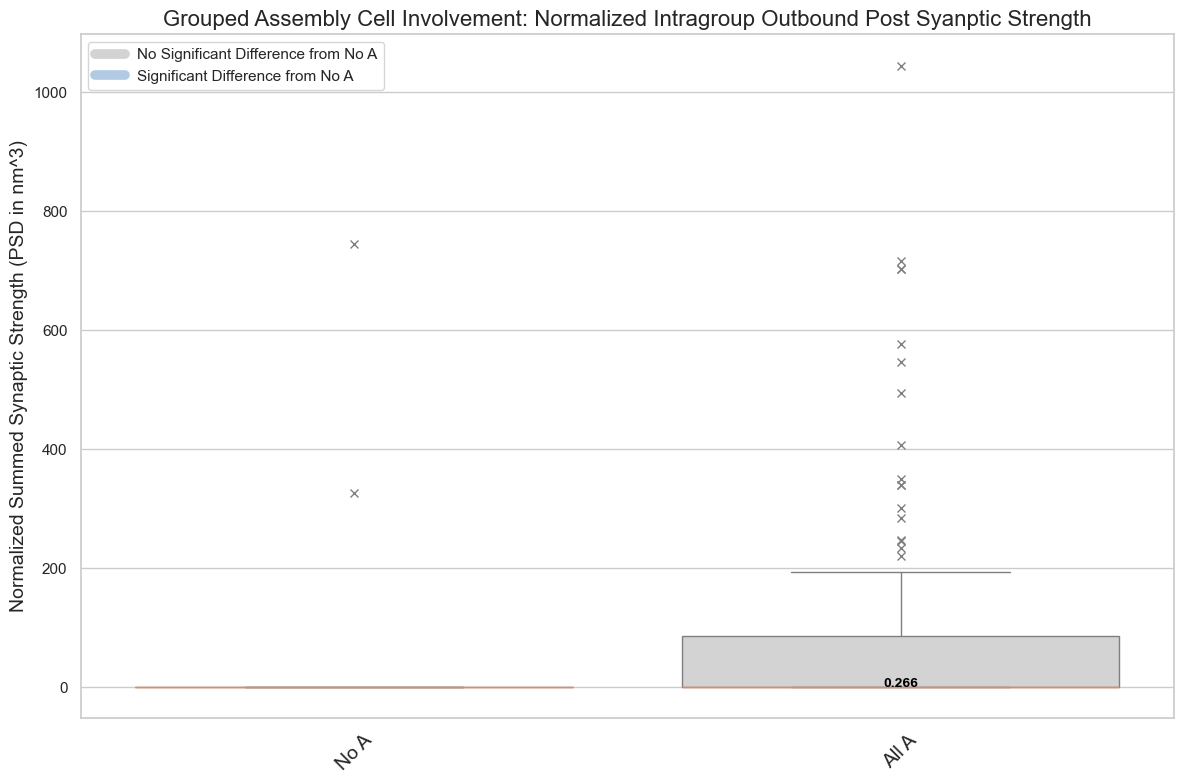

In [42]:
produce_first_order_connections_plot(input_connections_dict = grouped_intragroup_outbound_summed_psd_first_order_connections, 
                                     total_cells = summed_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = True,
                                     average_psd = False, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

### First-Order Analysis with Average PSD Connectome

In [43]:
outbound_averaged_psd_first_order_connections = {}
inbound_averaged_psd_first_order_connections = {}
outbound_averaged_psd_intragroup_first_order_connections = {}
inbound_averaged_psd_intragroup_first_order_connections = {}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        outbound_averaged_psd_first_order_connections[A] = []
        inbound_averaged_psd_first_order_connections[A] = []
        outbound_averaged_psd_intragroup_first_order_connections[A] = []
        inbound_averaged_psd_intragroup_first_order_connections[A] = []
        for connectome_id in assemblies_by_coregistered[A]:
            outbound_averaged_psd_first_order_connections[A].append(np.sum(average_size_connectome[connectome_id,:]))
            inbound_averaged_psd_first_order_connections[A].append(np.sum(average_size_connectome[:,connectome_id]))
            outbound_averaged_psd_intragroup_first_order_connections[A].append(np.sum(average_size_connectome[connectome_id,assemblies_by_coregistered[A]]))
            inbound_averaged_psd_intragroup_first_order_connections[A].append(np.sum(average_size_connectome[assemblies_by_coregistered[A], connectome_id]))

print("Outbound Averaged PSD: ", outbound_averaged_psd_first_order_connections)
print("Inbound Averaged PSD: ", inbound_averaged_psd_first_order_connections)
print("Outbound Averaged PSD Intragroup: ", outbound_averaged_psd_intragroup_first_order_connections)
print("Inbound Averaged PSD Intragroup: ", inbound_averaged_psd_intragroup_first_order_connections)

Outbound Averaged PSD:  {'A 1': [121429.92380952381, 71336.25, 63893.83333333333, 68272.70833333333, 37605.16666666667, 97311.65075757576, 84613.16666666667, 72039.75, 83816.05303030304, 100989.83333333334, 39231.333333333336, 59140.833333333336, 34809.66666666667, 15410.333333333332, 61237.799999999996, 67445.9, 65337.16666666666, 52451.566666666666, 79546.56666666667, 70890.55, 58660.75], 'A 3': [71336.25, 37605.16666666667, 100989.83333333334, 59140.833333333336, 34809.66666666667, 52451.566666666666, 58660.75, 41652.166666666664, 43622.0, 31394.73333333333], 'A 4': [71336.25, 84613.16666666667, 72039.75, 67445.9, 52451.566666666666, 61318.38333333333, 126094.95000000001, 61867.7, 48244.63333333333, 85401.2619047619], 'A 5': [71336.25, 68272.70833333333, 59140.833333333336, 61318.38333333333, 48244.63333333333, 85401.2619047619, 62802.5, 49433.83333333333], 'A 7': [71336.25, 68272.70833333333, 84613.16666666667, 72039.75, 43622.0, 48244.63333333333, 85401.2619047619, 62802.5], 'A 8'

In [44]:
# Produce Grouped Counts for Inbound and Outbound Connections
grouped_outbound_averaged_psd_first_order_connections = {'No A': [], "All A": [], "Non-Reg": []}
grouped_inbound_averaged_psd_first_order_connections = {'No A': [], "All A": [], "Non-Reg": []}
grouped_intragroup_outbound_averaged_psd_first_order_connections = {'No A': [], "All A": [], "Non-Reg": []}
grouped_intragroup_inbound_averaged_psd_first_order_connections = {'No A': [], "All A": [], "Non-Reg": []}

non_intragroup_assembly_indexes = set()
for A, group_indexes in assemblies_by_coregistered.items():
    if len(group_indexes) < 2:
        continue
    
    for c_index in group_indexes:
        outbound_sum = np.sum(average_size_connectome[c_index,:])
        inbound_sum = np.sum(average_size_connectome[:,c_index])
        # Will normalize already by all possible connections in group
        intragroup_outbound_sum = np.sum(average_size_connectome[c_index,group_indexes]) / (len(group_indexes) - 1)
        intragroup_inbound_sum = np.sum(average_size_connectome[group_indexes,c_index]) / (len(group_indexes) - 1)
        if A == 'No A':
            grouped_outbound_averaged_psd_first_order_connections['No A'].append(outbound_sum)
            grouped_inbound_averaged_psd_first_order_connections['No A'].append(inbound_sum)
            grouped_intragroup_outbound_averaged_psd_first_order_connections['No A'].append(intragroup_outbound_sum)
            grouped_intragroup_inbound_averaged_psd_first_order_connections['No A'].append(intragroup_inbound_sum)
        else:
            grouped_intragroup_outbound_averaged_psd_first_order_connections['All A'].append(intragroup_outbound_sum)
            grouped_intragroup_inbound_averaged_psd_first_order_connections['All A'].append(intragroup_inbound_sum)
            # Make sure there is no double counting in non-intragroup analysis
            if c_index not in non_intragroup_assembly_indexes:
                grouped_outbound_averaged_psd_first_order_connections['All A'].append(outbound_sum)
                grouped_inbound_averaged_psd_first_order_connections['All A'].append(inbound_sum)
                non_intragroup_assembly_indexes.add(c_index)

# Add Analysis for non-registered ids
for c_index in non_registered_ids:
    outbound_sum = np.sum(average_size_connectome[c_index,:])
    inbound_sum = np.sum(average_size_connectome[:,c_index])
    grouped_outbound_averaged_psd_first_order_connections['Non-Reg'].append(outbound_sum)
    grouped_inbound_averaged_psd_first_order_connections['Non-Reg'].append(inbound_sum)

print("Grouped Outbound Averaged PSD: ", grouped_outbound_averaged_psd_first_order_connections)
print("Grouped Inbound Averaged PSD: ", grouped_inbound_averaged_psd_first_order_connections)
print("Grouped Outbound Averaged PSD Intragroup: ", grouped_intragroup_outbound_averaged_psd_first_order_connections)
print("Grouped Inbound Averaged PSD Intragroup: ", grouped_intragroup_inbound_averaged_psd_first_order_connections)

Grouped Outbound Averaged PSD:  {'No A': [19987.666666666668, 65904.03333333333, 49345.75, 64278.08333333333, 70125.0, 62457.5, 65890.08333333333, 75660.66666666667, 36294.16666666667, 29321.5, 52513.23333333334, 41108.5], 'All A': [121429.92380952381, 71336.25, 63893.83333333333, 68272.70833333333, 37605.16666666667, 97311.65075757576, 84613.16666666667, 72039.75, 83816.05303030304, 100989.83333333334, 39231.333333333336, 59140.833333333336, 34809.66666666667, 15410.333333333332, 61237.799999999996, 67445.9, 65337.16666666666, 52451.566666666666, 79546.56666666667, 70890.55, 58660.75, 41652.166666666664, 43622.0, 31394.73333333333, 61318.38333333333, 126094.95000000001, 61867.7, 48244.63333333333, 85401.2619047619, 62802.5, 49433.83333333333, 67247.20000000001, 103591.9, 71618.41666666666, 62477.85, 51248.833333333336, 44292.33333333333, 65434.166666666664, 52905.95, 137664.9166666667, 36901.15], 'Non-Reg': [92511.05, 54525.33199202758, 52420.83333333333, 91085.92005494505, 39930.5, 7

[       nan 0.04608285 0.11349721 0.62918298 0.02792506 0.15793724
 0.03799119 0.03203875 0.01750749]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


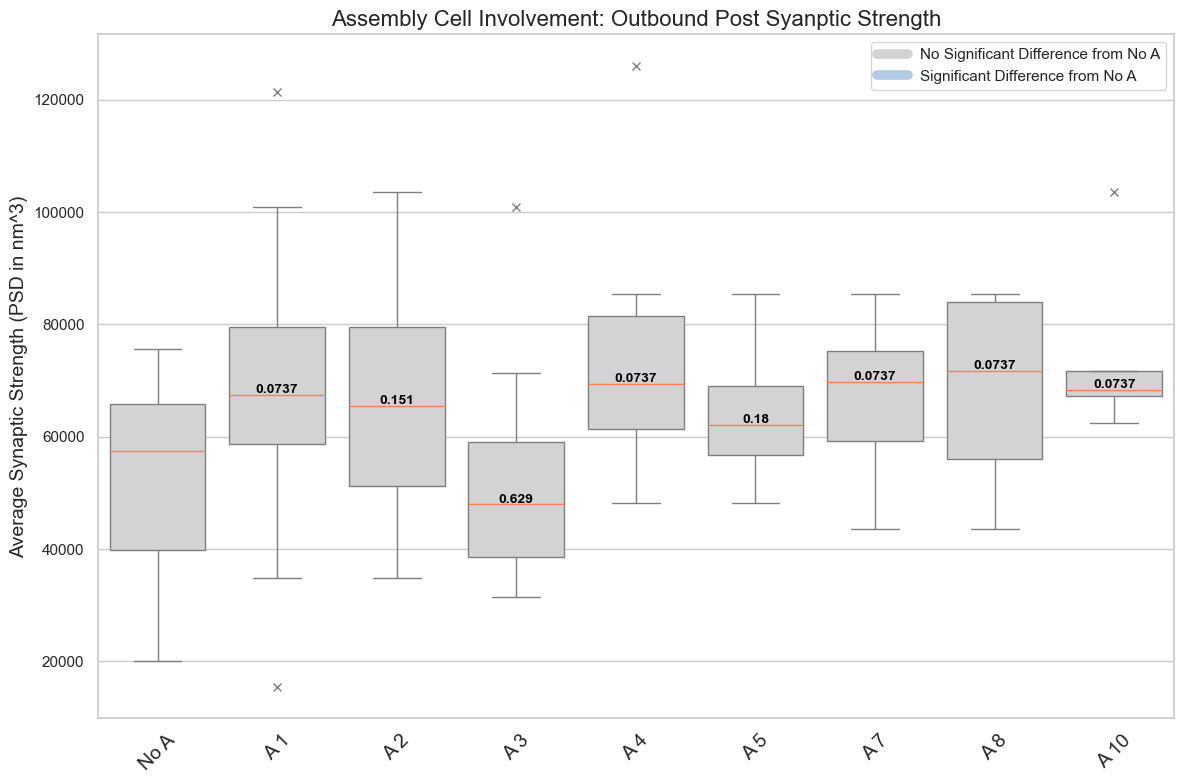

In [45]:
produce_first_order_connections_plot(input_connections_dict = outbound_averaged_psd_first_order_connections, 
                                     total_cells = average_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

[       nan 0.11554225 0.17777706 0.21439714 0.72355745 0.80196709
 0.67828558 0.53074856 0.5       ]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


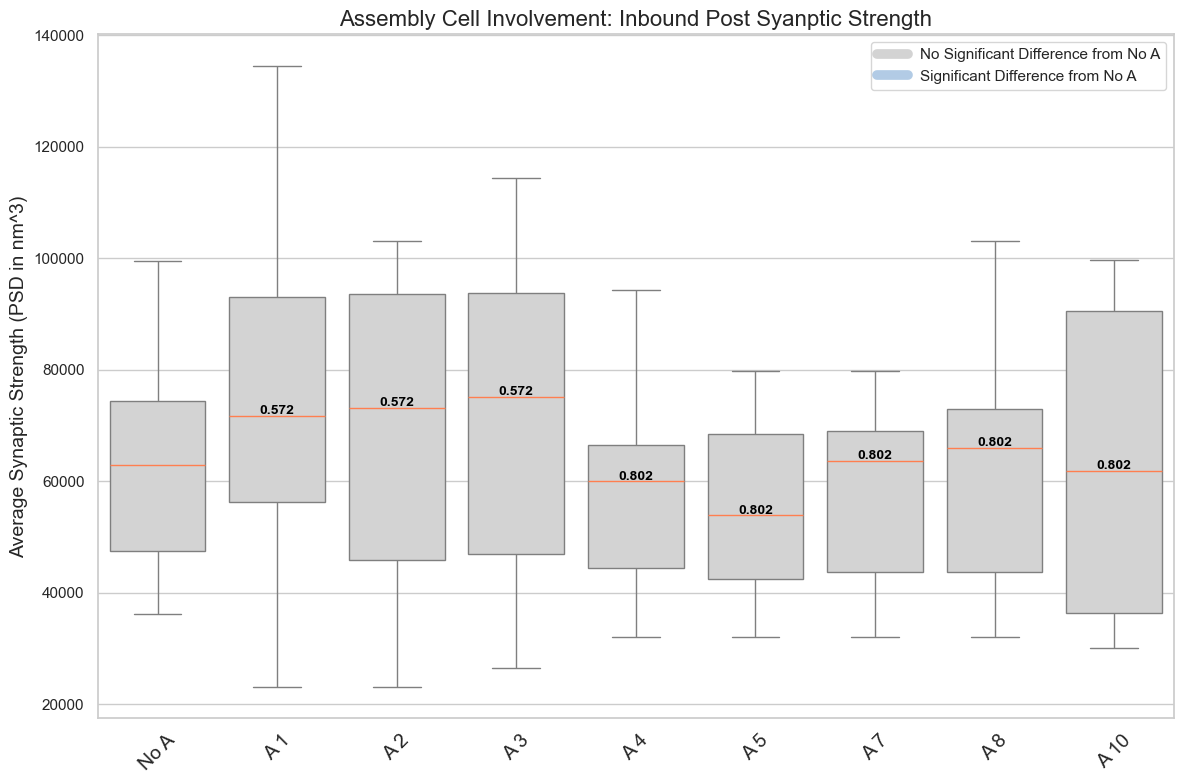

In [46]:
produce_first_order_connections_plot(input_connections_dict = inbound_averaged_psd_first_order_connections, 
                                     total_cells = average_size_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = False,
                                     show_p_vals = True,
                                     fdr_correction = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


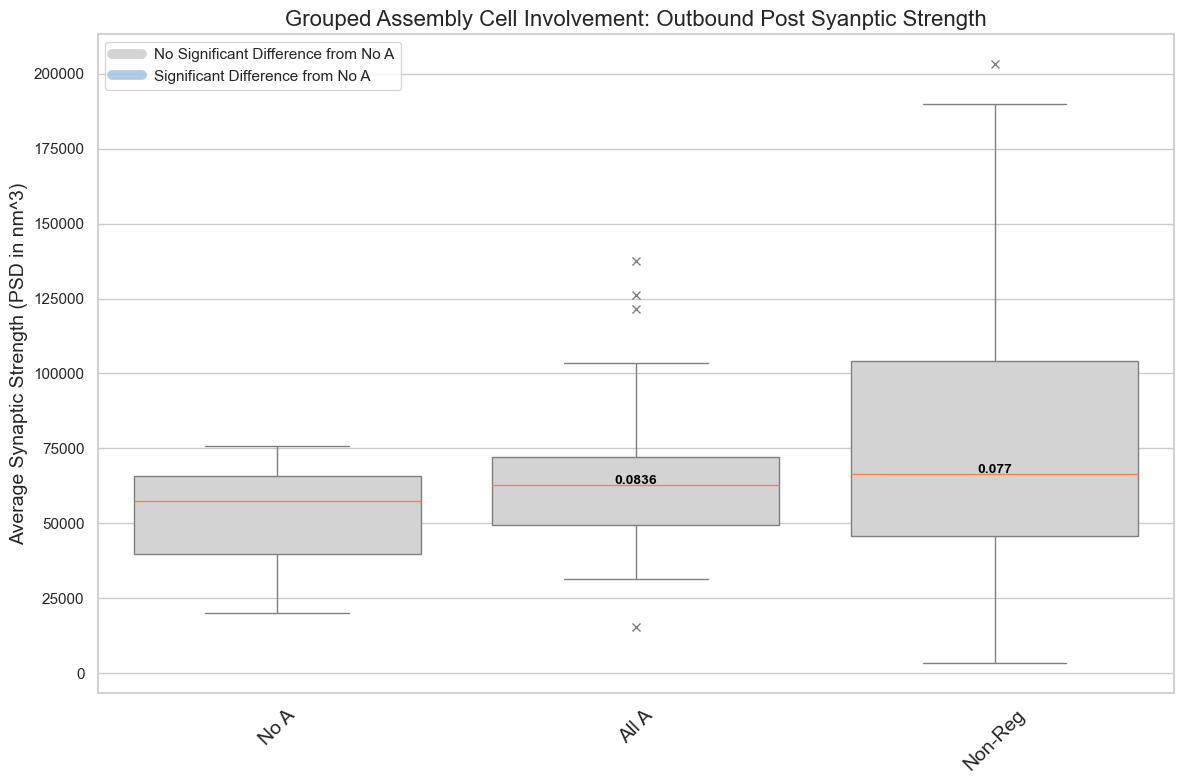

In [47]:
produce_first_order_connections_plot(input_connections_dict = grouped_outbound_averaged_psd_first_order_connections, 
                                     total_cells = average_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True,
                                     include_non_registered = True)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


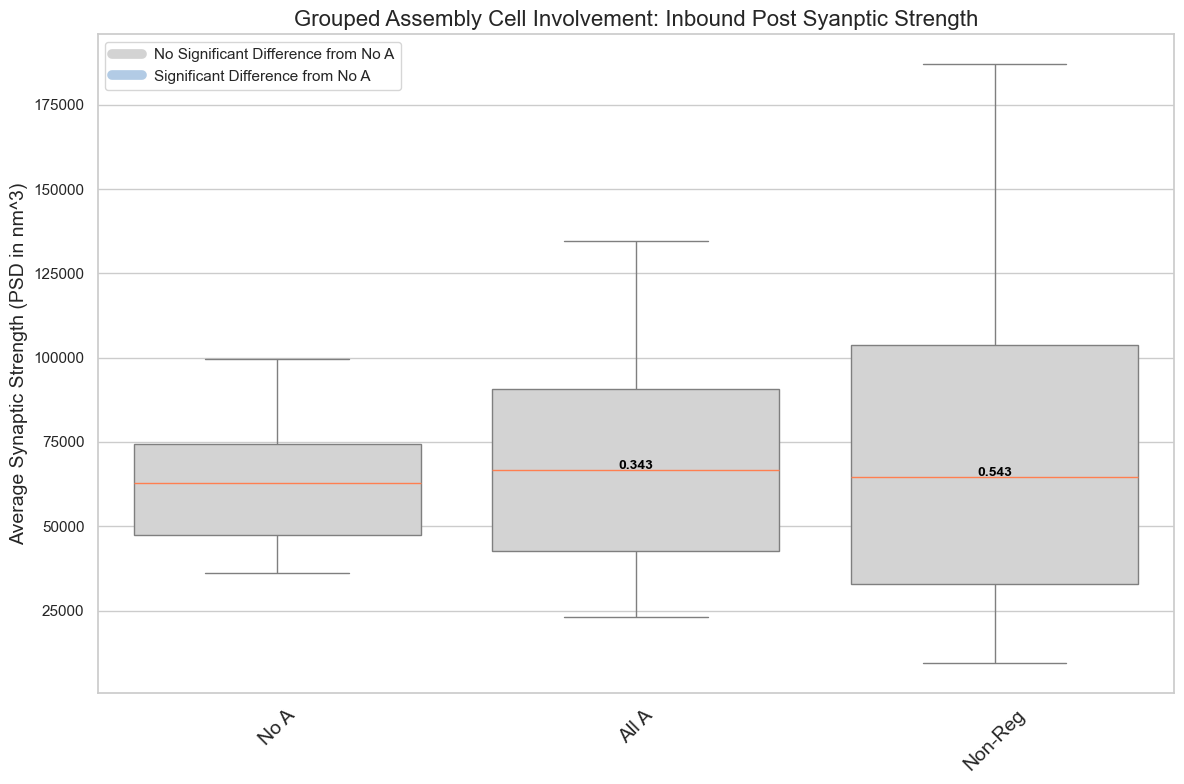

In [48]:
produce_first_order_connections_plot(input_connections_dict = grouped_inbound_averaged_psd_first_order_connections, 
                                     total_cells = average_size_connectome.shape[0],
                                     directionality = "Inbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     prob = False,
                                     intragroup = False,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True,
                                     include_non_registered = True)

Probability Already Normalized.
Probability Already Normalized.
Probability Already Normalized.


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/1761983475.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


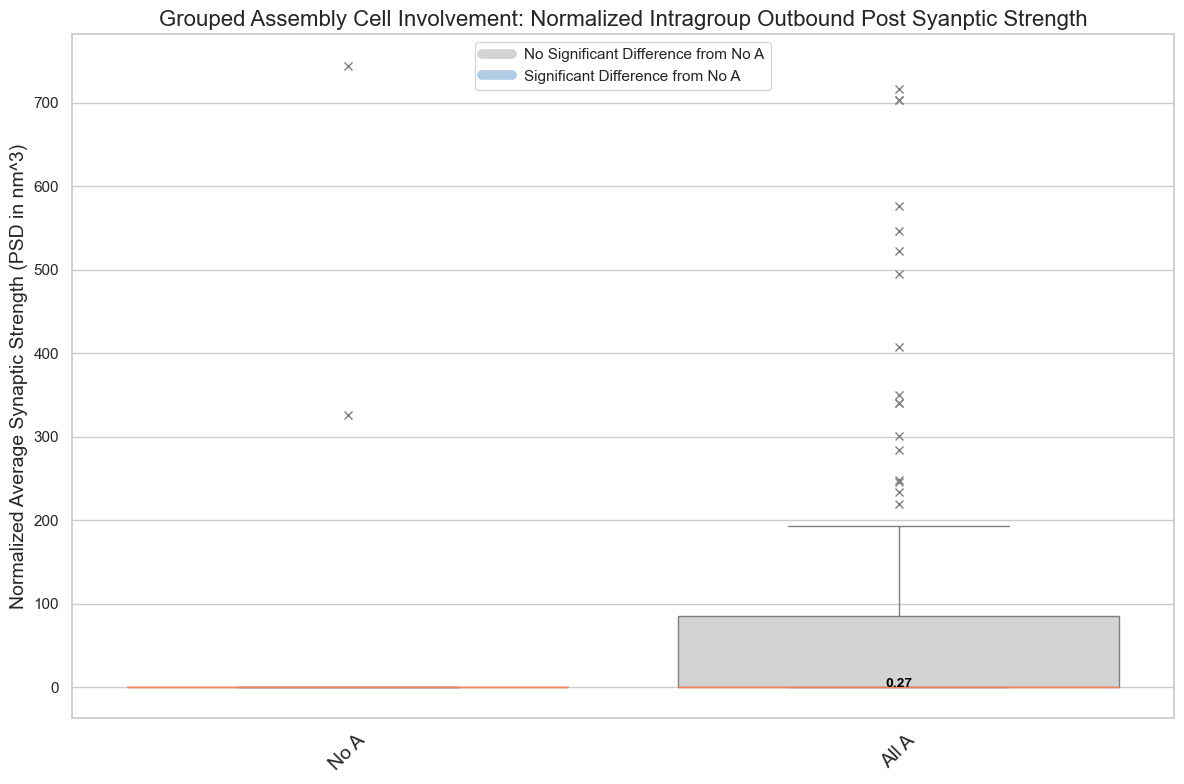

In [49]:
produce_first_order_connections_plot(input_connections_dict = grouped_intragroup_outbound_averaged_psd_first_order_connections, 
                                     total_cells = average_size_connectome.shape[0],
                                     directionality = "Outbound",
                                     binary_counts = False,
                                     syn_counts = False, 
                                     summed_psd = False,
                                     average_psd = True, 
                                     prob = True,
                                     intragroup = True,
                                     grouped = True,
                                     show_p_vals = True,
                                     fdr_correction = True)

### Higher-Order Analysis: Min-Cost Path

In [50]:
assembly_connectome_indexes = np.array(assembly_connectome_indexes)
no_assembly_connectome_indexes = np.array(no_assembly_connectome_indexes)
print(assembly_connectome_indexes)
print(no_assembly_connectome_indexes)

[377 303  10 630 458 126 749 162 225 535 701 429 663 353 425 125 201  27
 837 329 763  68 109 454 730 800 391 304 229 374  52 659 806 161 715 243
 845 563 633  73 728 710 298]
[597 255 379 764 770 234  34 419 484 799 808  89]


In [51]:
# Create graph from the binary connectome, and set weights as average PSD
G = nx.DiGraph()
for i in range(binary_connectome.shape[0]):
    for j in range(binary_connectome.shape[1]):
        if binary_connectome[i, j] == 1:  # There is a connection
            # Every synapse would be noramlized by the sum of the psd values which are contirbuting to the same post-syanptic neurons
            G.add_edge(i, j, weight = -np.log(summed_size_connectome[i,j] / sum(summed_size_connectome[:,j])))

# Calculate minimum-cost paths within assembly neurons
assembly_min_cost_paths = []
for i in range(len(assembly_connectome_indexes)):
    for j in range(i + 1, len(assembly_connectome_indexes)):
        try:
            length = nx.shortest_path_length(G, source = assembly_connectome_indexes[i], target = assembly_connectome_indexes[j], weight='weight')
            assembly_min_cost_paths.append(length)
        except nx.NetworkXNoPath:
            assembly_min_cost_paths.append(np.inf)

# Calculate minimum-cost paths within non-assembly neurons
non_assembly_min_cost_paths = []
for i in range(len(no_assembly_connectome_indexes)):
    for j in range(i + 1, len(no_assembly_connectome_indexes)):
        try:
            length = nx.shortest_path_length(G, source = no_assembly_connectome_indexes[i], target = no_assembly_connectome_indexes[j], weight='weight')
            non_assembly_min_cost_paths.append(length)
        except nx.NetworkXNoPath:
            non_assembly_min_cost_paths.append(np.inf)

# Filter out np.inf values for meaningful comparisons
#assembly_min_cost_paths = [val for val in assembly_min_cost_paths if val != np.inf]
#non_assembly_min_cost_paths = [val for val in non_assembly_min_cost_paths if val != np.inf]

# Calculate and print statistics
print(f"Assembly Neurons: Mean path length = {np.mean(assembly_min_cost_paths)}, Median path length = {np.median(assembly_min_cost_paths)}")
print(f"Non-Assembly Neurons: Mean path length = {np.mean(non_assembly_min_cost_paths)}, Median path length = {np.median(non_assembly_min_cost_paths)}")

Assembly Neurons: Mean path length = 7.7266781496981, Median path length = 7.821267857365503
Non-Assembly Neurons: Mean path length = 7.708483637553979, Median path length = 7.886639879120462


Wilcox Rank-Sum:  0.8336318888588679
T-Test:  0.4382147797223298


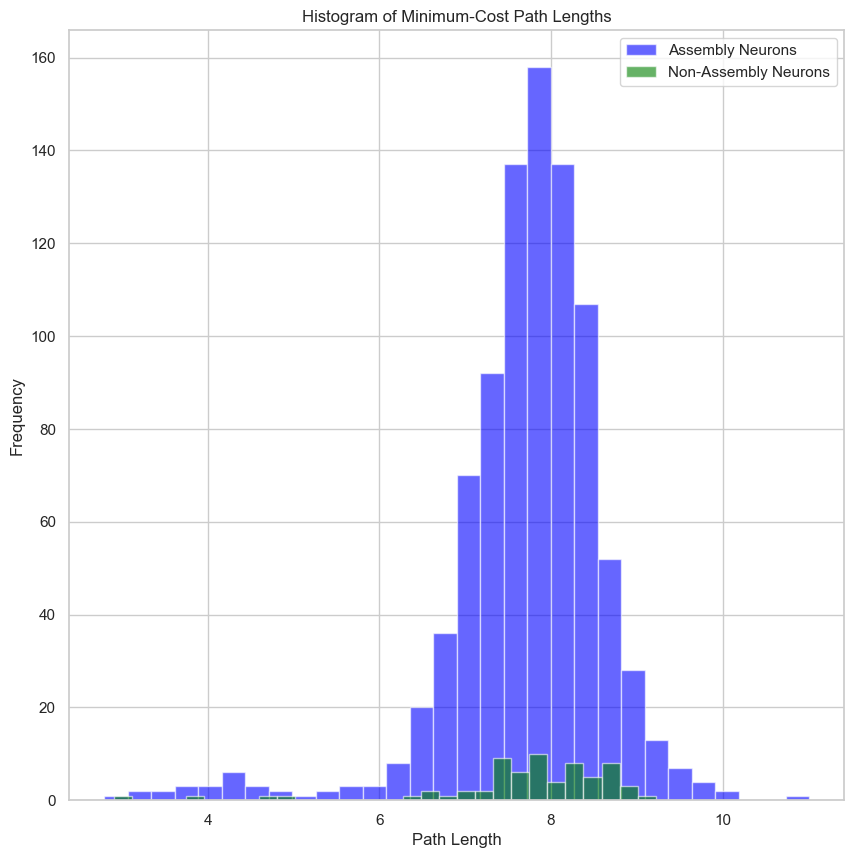

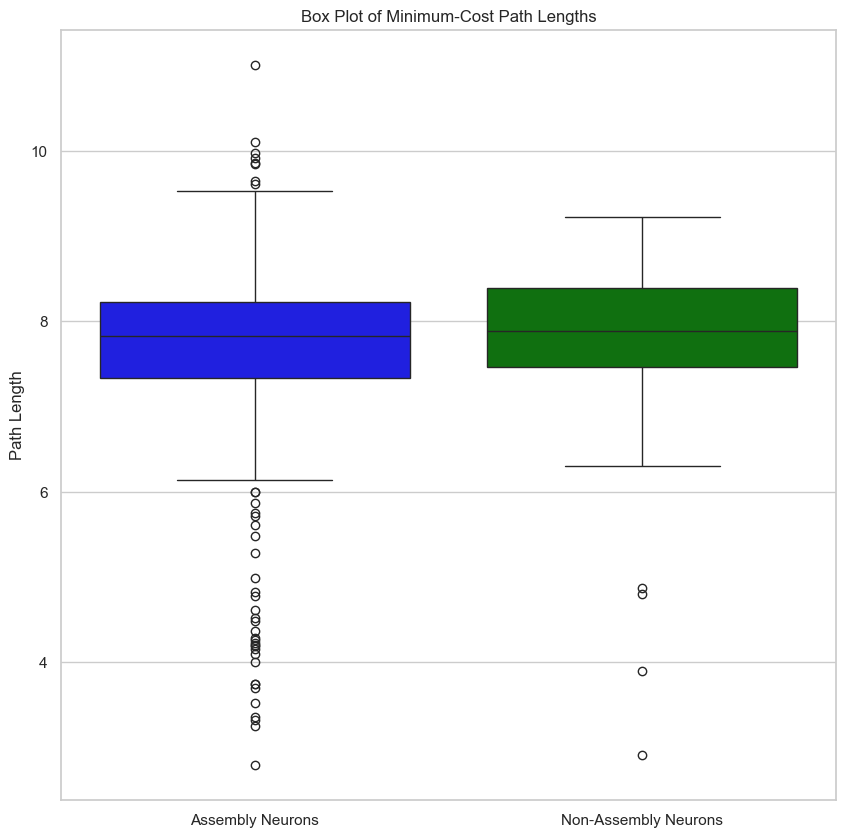

In [52]:
print("Wilcox Rank-Sum: ", stats.ranksums(assembly_min_cost_paths, non_assembly_min_cost_paths, alternative='greater').pvalue)
print("T-Test: ", stats.ttest_ind(assembly_min_cost_paths, non_assembly_min_cost_paths, alternative='greater').pvalue)

plt.hist(assembly_min_cost_paths, bins=30, color='blue', alpha=0.6, label='Assembly Neurons')
plt.hist(non_assembly_min_cost_paths, bins=30, color='green', alpha=0.6, label='Non-Assembly Neurons')
plt.title('Histogram of Minimum-Cost Path Lengths')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

sns.boxplot(data=[assembly_min_cost_paths, non_assembly_min_cost_paths], palette=['blue', 'green'])
plt.xticks([0, 1], ['Assembly Neurons', 'Non-Assembly Neurons'])
plt.title('Box Plot of Minimum-Cost Path Lengths')
plt.ylabel('Path Length')
plt.show()

In [53]:
# Create graph from the binary connectome, and set weights as average PSD
G = nx.DiGraph()
for i in range(binary_connectome.shape[0]):
    for j in range(binary_connectome.shape[1]):
        if binary_connectome[i, j] == 1:  # There is a connection
            # Every synapse would be noramlized by the sum of the psd values which are contirbuting to the same post-syanptic neurons
            G.add_edge(i, j, weight = -np.log(summed_size_connectome[i,j] / sum(summed_size_connectome[:,j])))

# Calculate minimum-cost paths within assembly neurons
assembly_min_cost_paths = []
for A in assemblies_by_coregistered:
    if A != 'No A':
        for i in range(len(assemblies_by_coregistered[A])):
            for j in range(i + 1, len(assemblies_by_coregistered[A])):
                try:
                    length = nx.shortest_path_length(G, source = assemblies_by_coregistered[A][i], target = assemblies_by_coregistered[A][j], weight='weight')
                    assembly_min_cost_paths.append(length)
                except nx.NetworkXNoPath:
                    assembly_min_cost_paths.append(np.inf)

# Calculate minimum-cost paths within non-assembly neurons
non_assembly_min_cost_paths = []
for i in range(len(no_assembly_connectome_indexes)):
    for j in range(i + 1, len(no_assembly_connectome_indexes)):
        try:
            length = nx.shortest_path_length(G, source = no_assembly_connectome_indexes[i], target = no_assembly_connectome_indexes[j], weight='weight')
            non_assembly_min_cost_paths.append(length)
        except nx.NetworkXNoPath:
            non_assembly_min_cost_paths.append(np.inf)

# Filter out np.inf values for meaningful comparisons
#assembly_min_cost_paths = [val for val in assembly_min_cost_paths if val != np.inf]
#non_assembly_min_cost_paths = [val for val in non_assembly_min_cost_paths if val != np.inf]


# Calculate and print statistics
print(f"Assembly Neurons: Intra-Group mean path length = {np.mean(assembly_min_cost_paths)}, Median path length = {np.median(assembly_min_cost_paths)}")
print(f"Non-Assembly Neurons: Intra-Group mean path length = {np.mean(non_assembly_min_cost_paths)}, Median path length = {np.median(non_assembly_min_cost_paths)}")

Assembly Neurons: Intra-Group mean path length = 7.743854525291828, Median path length = 7.867416695874619
Non-Assembly Neurons: Intra-Group mean path length = 7.708483637553979, Median path length = 7.886639879120462


Wilcox Rank-Sum:  0.6472731294660714
T-Test:  0.3947538701093761


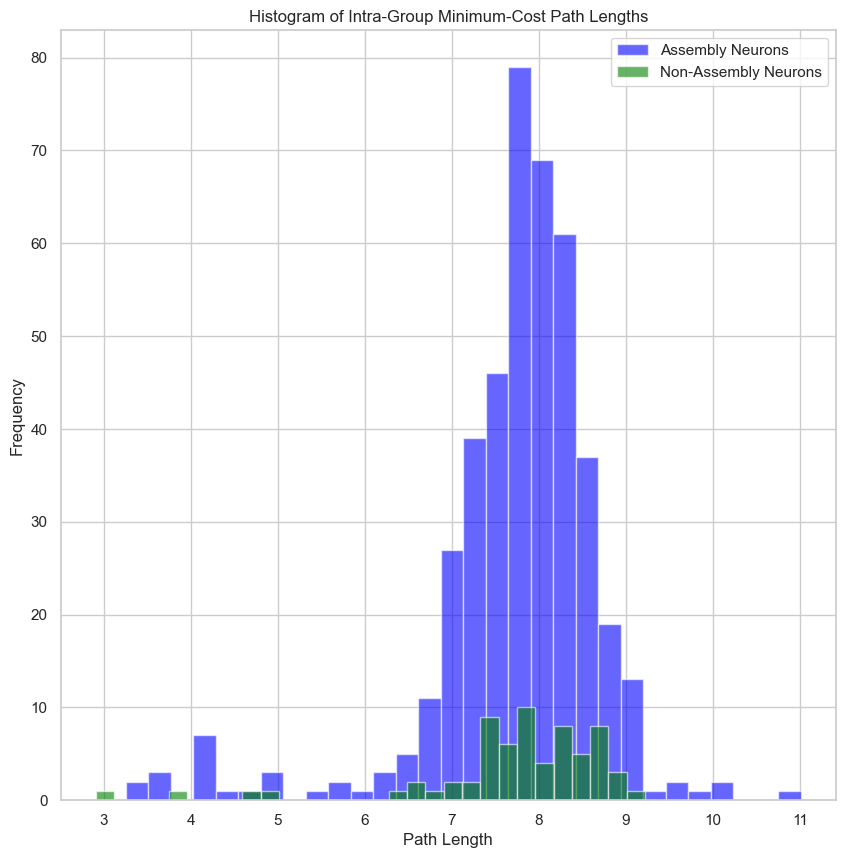

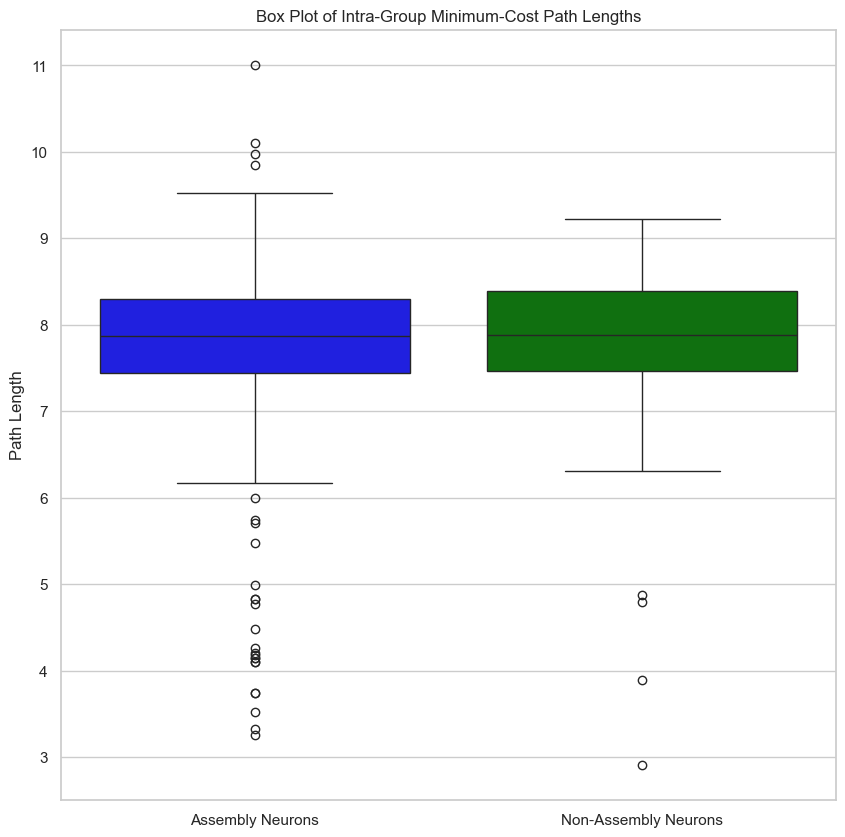

In [54]:
print("Wilcox Rank-Sum: ", stats.ranksums(assembly_min_cost_paths, non_assembly_min_cost_paths, alternative='greater').pvalue)
print("T-Test: ", stats.ttest_ind(assembly_min_cost_paths, non_assembly_min_cost_paths, alternative='greater').pvalue)

plt.hist(assembly_min_cost_paths, bins=30, color='blue', alpha=0.6, label='Assembly Neurons')
plt.hist(non_assembly_min_cost_paths, bins=30, color='green', alpha=0.6, label='Non-Assembly Neurons')
plt.title('Histogram of Intra-Group Minimum-Cost Path Lengths')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

sns.boxplot(data=[assembly_min_cost_paths, non_assembly_min_cost_paths], palette=['blue', 'green'])
plt.xticks([0, 1], ['Assembly Neurons', 'Non-Assembly Neurons'])
plt.title('Box Plot of Intra-Group Minimum-Cost Path Lengths')
plt.ylabel('Path Length')
plt.show()

### First-Order Analysis: Centrality

In [55]:
def produce_centrality_plot(input_centrality_dict: dict,
                            outdegree: bool,
                            indegree: bool, 
                            closeness: bool, 
                            betweeness : bool,
                            grouped: bool,
                            show_p_vals: bool, 
                            fdr_correction: bool,
                            include_non_registered = False,
                            save_fig = True):
    
    if outdegree and indegree:
        raise ValueError("Must either be working with outdegree or indegree.")
    if closeness and betweeness:
        raise ValueError("Must either be working with closeness or betweeness.")
    if (outdegree or indegree) and (closeness or betweeness):
        raise ValueError("Must either be working with directionality or higher-order.")
    
    # Based on the connectome flags, save it in the right folder, set the correct y_label and plot title
    if outdegree:
        centrality_desc = "Outdegree_Centrality"
        folder = "binary_connectome"
        suffix = "Outdegree Centrality"
        y_lab = "Outdegree Centrality"
    elif indegree:
        centrality_desc = "Indegree_Centrality"
        folder = "binary_connectome"
        suffix = "Indegree Centrality"
        y_lab = "Indegree Centrality"
    elif closeness: 
        centrality_desc = "Closeness_Centrality"
        folder = "binary_connectome"
        suffix = "Closeness Centrality"
        y_lab = "Closeness Centrality"
    elif betweeness:
        centrality_desc = "Betweeness_Centrality"
        folder = "binary_connectome"
        suffix = "Betweeness Centrality"
        y_lab = "Betweeness Centrality"
    else:
        centrality_desc = "Degree_Centrality"
        folder = "binary_connectome"
        suffix = "Degree Centrality"
        y_lab = "Degree Centrality"

    centrality_dict = {}
    for key in input_centrality_dict.keys():
        centrality_dict[key] = np.array(input_centrality_dict[key])

    prefix = 'Grouped ' if grouped else ""

    if not grouped:
        all_arr = [centrality_dict['No A']]
        x_ticks = ["No A"]
        arr_medians = [np.median(np.array(centrality_dict['No A']))]
        p_values = [np.nan]
        # Sort the dictionary keys
        sorted_keys = sorted(centrality_dict.keys(), key=lambda s: (0, 0) if s == 'No A' else (1, int(s.split()[1])))
        for key in sorted_keys:
            if key != 'No A':
                if len(centrality_dict[key]) < 5:
                    print(f"No Empirical Testing Performed. Assembly {key} has less than 5 coregistered cells.")
                    continue
                all_arr.append(centrality_dict[key])
                x_ticks.append(key)
                arr_medians.append(np.median(np.array(centrality_dict[key])))
                p_values.append(stats.ranksums(centrality_dict[key], centrality_dict['No A'], 'greater').pvalue)
        
        # Perform False Discoery Correction for our P-Values
        p_values = np.array(p_values)
        print(p_values)
        if fdr_correction:
            p_values[1:] = stats.false_discovery_control(p_values[1:], method = 'bh')
        for i, val in enumerate(p_values):
            p_values[i] = '{:.3g}'.format(val, 5) if i != 0 else p_values[i]
    elif include_non_registered:
        all_arr = [centrality_dict['No A'], centrality_dict['All A'], centrality_dict['Non-Reg']]
        x_ticks = ["No A", 'All A', 'Non-Reg']
        arr_medians = [np.median(np.array(centrality_dict['No A'])), np.median(np.array(centrality_dict['All A'])), np.median(np.array(centrality_dict['Non-Reg']))]
        all_a_val = stats.ranksums(centrality_dict['All A'], centrality_dict['No A'], 'greater').pvalue
        non_registered_val = stats.ranksums(centrality_dict['Non-Reg'], centrality_dict['No A'], 'greater').pvalue
        p_values = [np.nan, '{:.3g}'.format(all_a_val, 5), '{:.3g}'.format(non_registered_val, 5)]
    else:
        all_arr = [centrality_dict['No A'], centrality_dict['All A']]
        x_ticks = ["No A", 'All A']
        arr_medians = [np.median(np.array(centrality_dict['No A'])), np.median(np.array(centrality_dict['All A']))]
        val = stats.ranksums(centrality_dict['All A'], centrality_dict['No A'], 'greater').pvalue
        p_values = [np.nan, '{:.3g}'.format(val, 5)]

    # Define Colors based on Signfiicance
    colors = ['lightgrey' if float(p_val) >= 0.05 or np.isnan(float(p_val)) else (.4, .6, .8, .5) for p_val in p_values]

    # Create a figure with specific size
    _, ax = plt.subplots(figsize=(12, 8))  # Width = 12 inches, Height = 6 inches

    sns.set_theme(style="whitegrid")
    sns.boxplot(data=all_arr,
                    notch= False, showcaps=True,
                    flierprops={"marker": "x"},
                    medianprops={"color": "coral"},
                    palette= colors,
                    ax = ax
                )
    ax.set_xticklabels(x_ticks, size = 14)
    ax.set_title(f'{prefix}Assembly Cell Involvement: {suffix}', size = 16)
    ax.set_ylabel(y_lab, size = 14)
    plt.xticks(rotation=45)

    # Create legend
    custom_legend = [plt.Line2D([0], [0], color='lightgrey', lw=7, label='No Significant Difference from No A'),
                    plt.Line2D([0], [0], color=(.4, .6, .8, .5), lw=7, label='Significant Difference from No A')]
    plt.legend(handles=custom_legend, loc='best')

    # If you want to print P-Values, place them on the plot above the median

    if show_p_vals:
        medians = np.array(arr_medians)
        vertical_offset = medians * 0.005 # offset from median for display
            
        for xtick in ax.get_xticks():
            if xtick != 0:
                ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick],  # type: ignore
                        horizontalalignment='center', fontsize=10, color='black', weight='semibold')

    desc = "Grouped" if grouped else "All"
    fig_title = f"{centrality_desc}_{desc}_Assemblies_Boxplot.png"
    
    if save_fig:
        plt.savefig(f'{results_folder}/{folder}/{fig_title}', dpi = 1200)
    plt.tight_layout()
    plt.show()

In [56]:
all_to_all_graph = nx.from_numpy_array(binary_connectome, create_using=nx.DiGraph)
all_to_all_graph

In [57]:
centrality = nx.degree_centrality(all_to_all_graph)
indegree_centrality = nx.in_degree_centrality(all_to_all_graph)
outdegree_centrality = nx.out_degree_centrality(all_to_all_graph)
closeness_centrality = nx.closeness_centrality(all_to_all_graph, wf_improved = True)
betweeness_centrality = nx.betweenness_centrality(all_to_all_graph, normalized= True)

In [58]:
# Produce Counts for Inbound and Outbound Connections
centrality_by_membership = {}
indegree_centrality_by_membership = {}
outdegree_centrality_by_membership = {}
closeness_centrality_by_membership = {}
betweeness_centrality_by_membership = {}

for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 5:
        centrality_by_membership[A] = []
        indegree_centrality_by_membership[A] = []
        outdegree_centrality_by_membership[A] = []
        closeness_centrality_by_membership[A] = []
        betweeness_centrality_by_membership[A] = []
        for c_index in assemblies_by_coregistered[A]:
            centrality_by_membership[A].append(centrality[c_index])
            indegree_centrality_by_membership[A].append(indegree_centrality[c_index])
            outdegree_centrality_by_membership[A].append(outdegree_centrality[c_index])
            closeness_centrality_by_membership[A].append(closeness_centrality[c_index])
            betweeness_centrality_by_membership[A].append(betweeness_centrality[c_index])

print("Centrality: ", centrality_by_membership)
print("Indegree Centrality: ", indegree_centrality_by_membership)
print("Outdegree Centrality: ", outdegree_centrality_by_membership)
print("Closeness Centrality: ", closeness_centrality_by_membership)
print("Betweeness Centrality: ", betweeness_centrality_by_membership)

# Produce Grouped Counts for Inbound and Outbound Connections
centrality_by_grouped_membership = {'No A': [], 'All A': [], 'Non-Reg': []}
indegree_centrality_by_grouped_membership = {'No A': [], 'All A': [], 'Non-Reg': []}
outdegree_centrality_by_grouped_membership = {'No A': [], 'All A': [], 'Non-Reg': []}
closeness_centrality_by_grouped_membership = {'No A': [], 'All A': [], 'Non-Reg': []}
betweeness_centrality_by_grouped_membership = {'No A': [], 'All A': [], 'Non-Reg': []}

checked_indexes = set()
for A in assemblies_by_coregistered.keys():
    if len(assemblies_by_coregistered[A]) >= 1:
        for c_index in assemblies_by_coregistered[A]:
            if A == 'No A':
                centrality_by_grouped_membership['No A'].append(centrality[c_index])
                indegree_centrality_by_grouped_membership['No A'].append(indegree_centrality[c_index])
                outdegree_centrality_by_grouped_membership['No A'].append(outdegree_centrality[c_index])
                closeness_centrality_by_grouped_membership['No A'].append(closeness_centrality[c_index])
                betweeness_centrality_by_grouped_membership['No A'].append(betweeness_centrality[c_index])
            elif c_index not in checked_indexes:
                centrality_by_grouped_membership['All A'].append(centrality[c_index])
                indegree_centrality_by_grouped_membership['All A'].append(indegree_centrality[c_index])
                outdegree_centrality_by_grouped_membership['All A'].append(outdegree_centrality[c_index])
                closeness_centrality_by_grouped_membership['All A'].append(closeness_centrality[c_index])
                betweeness_centrality_by_grouped_membership['All A'].append(betweeness_centrality[c_index])
                checked_indexes.add(c_index)

# Add Analysis for non-registered ids
for c_index in non_registered_ids:
    centrality_by_grouped_membership['Non-Reg'].append(centrality[c_index])
    indegree_centrality_by_grouped_membership['Non-Reg'].append(indegree_centrality[c_index])
    outdegree_centrality_by_grouped_membership['Non-Reg'].append(outdegree_centrality[c_index])
    closeness_centrality_by_grouped_membership['Non-Reg'].append(closeness_centrality[c_index])
    betweeness_centrality_by_grouped_membership['Non-Reg'].append(betweeness_centrality[c_index])


print("Grouped Centrality: ", centrality_by_grouped_membership)
print("Grouped Indegree Centrality: ", indegree_centrality_by_grouped_membership)
print("Grouped Outdegree Centrality: ", outdegree_centrality_by_grouped_membership)
print("Grouped Closeness Centrality: ", closeness_centrality_by_grouped_membership)
print("Grouped Betweeness Centrality: ", betweeness_centrality_by_grouped_membership)

Centrality:  {'A 1': [0.22796709753231492, 0.12220916568742655, 0.16803760282021152, 0.1645123384253819, 0.17391304347826086, 0.20681551116333724, 0.16686251468860164, 0.1645123384253819, 0.2162162162162162, 0.20329024676850763, 0.11985898942420681, 0.1645123384253819, 0.15276145710928318, 0.09283196239717978, 0.14218566392479434, 0.15158636897767333, 0.1598119858989424, 0.13160987074030553, 0.11045828437132785, 0.12808460634547592, 0.15276145710928318], 'A 3': [0.12220916568742655, 0.17391304347826086, 0.20329024676850763, 0.1645123384253819, 0.15276145710928318, 0.13160987074030553, 0.15276145710928318, 0.13748531139835488, 0.12220916568742655, 0.06462984723854288], 'A 4': [0.12220916568742655, 0.16686251468860164, 0.1645123384253819, 0.15158636897767333, 0.13160987074030553, 0.12220916568742655, 0.22209165687426558, 0.12338425381903642, 0.14218566392479434, 0.13160987074030553], 'A 5': [0.12220916568742655, 0.1645123384253819, 0.1645123384253819, 0.12220916568742655, 0.1421856639247

In [59]:
print(len(closeness_centrality_by_grouped_membership['No A']))
print(len(closeness_centrality_by_grouped_membership['All A']))
print(len(closeness_centrality_by_grouped_membership['Non-Reg']))

12
43
50


[       nan 0.04791942 0.24979481 0.28757829 0.27644255 0.37881036
 0.15793724 0.17726974 0.14592027]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/2325728411.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


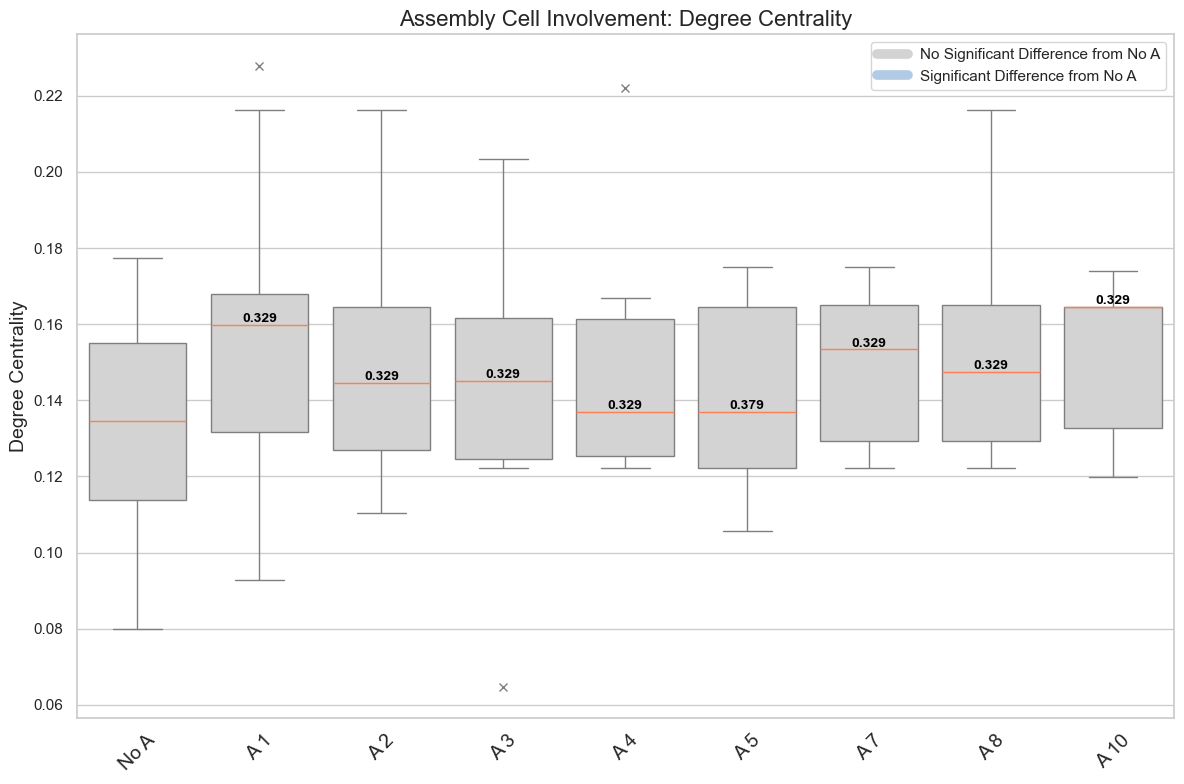

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/2325728411.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


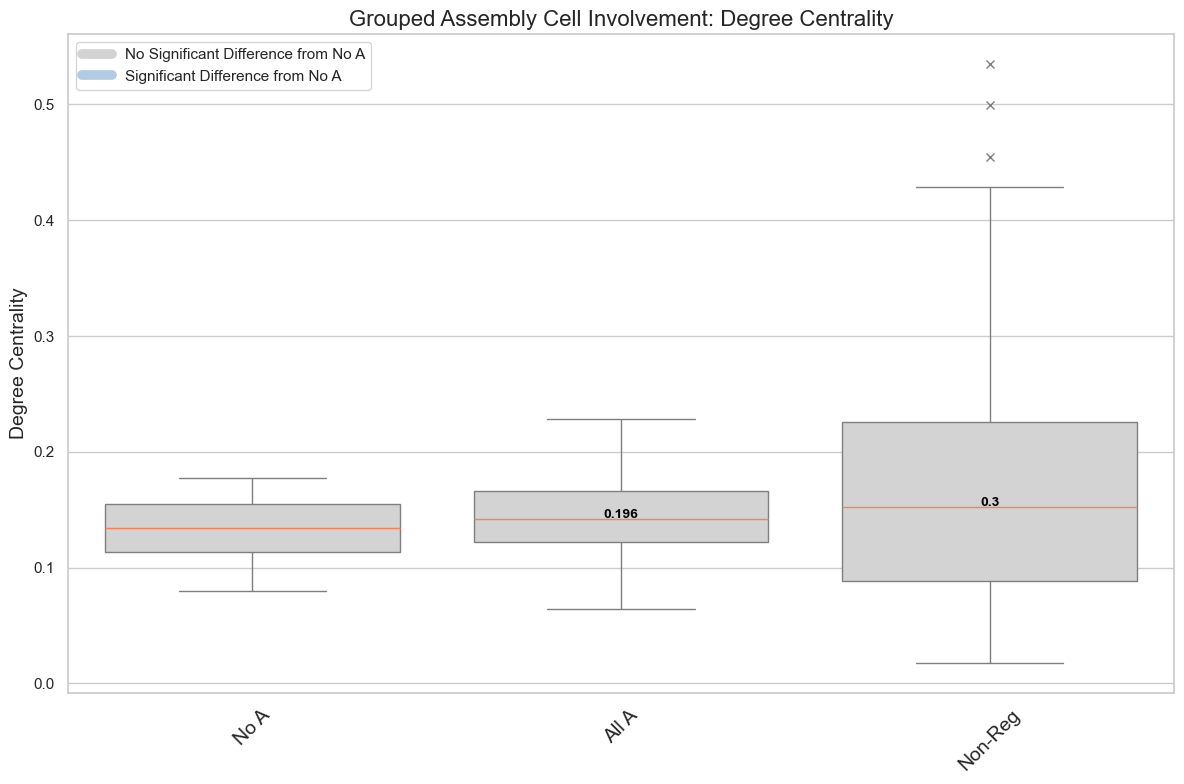

In [60]:
produce_centrality_plot(input_centrality_dict = centrality_by_membership,
                        outdegree = False,
                        indegree = False, 
                        closeness = False, 
                        betweeness = False,
                        grouped = False,
                        show_p_vals = True, 
                        fdr_correction = True,
                        save_fig = True)

produce_centrality_plot(input_centrality_dict = centrality_by_grouped_membership,
                        outdegree = False,
                        indegree = False, 
                        closeness = False, 
                        betweeness = False,
                        grouped = True,
                        show_p_vals = True, 
                        fdr_correction = True,
                        include_non_registered = True,
                        save_fig = True)

[       nan 0.04430325 0.18717993 0.70107831 0.02047285 0.17726974
 0.02457042 0.01537678 0.00885303]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/2325728411.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


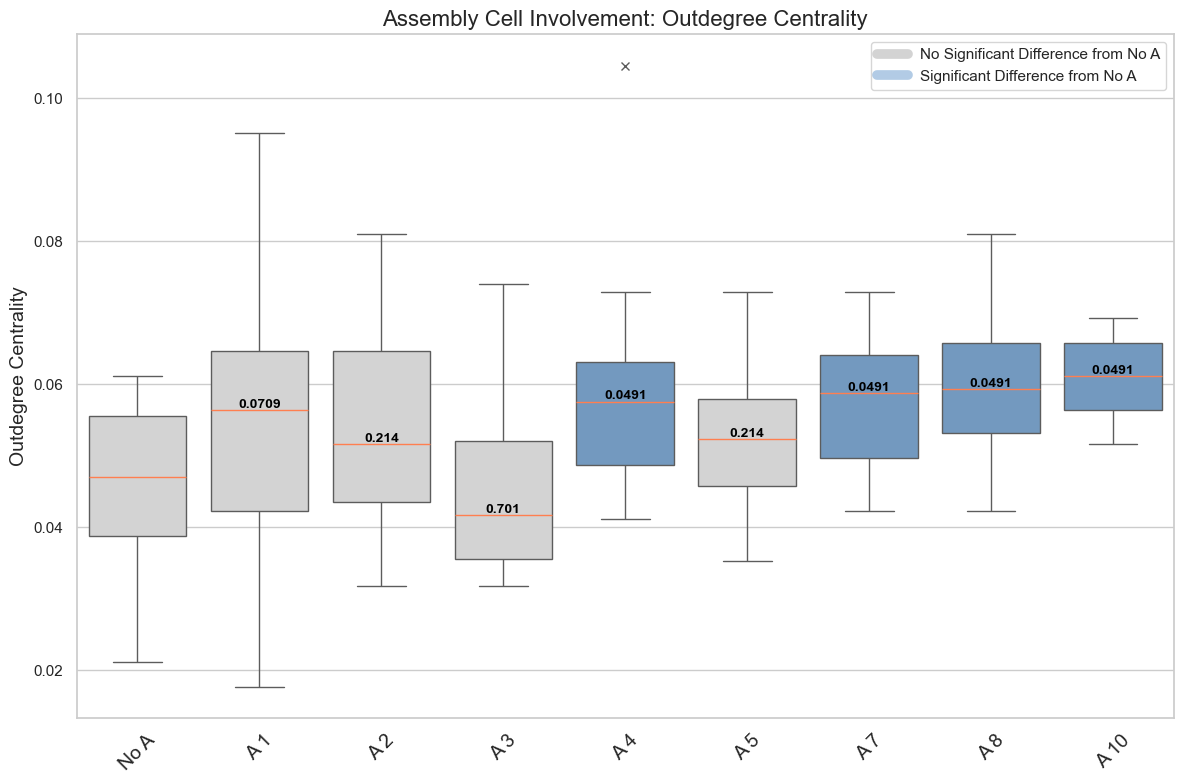

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/2325728411.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


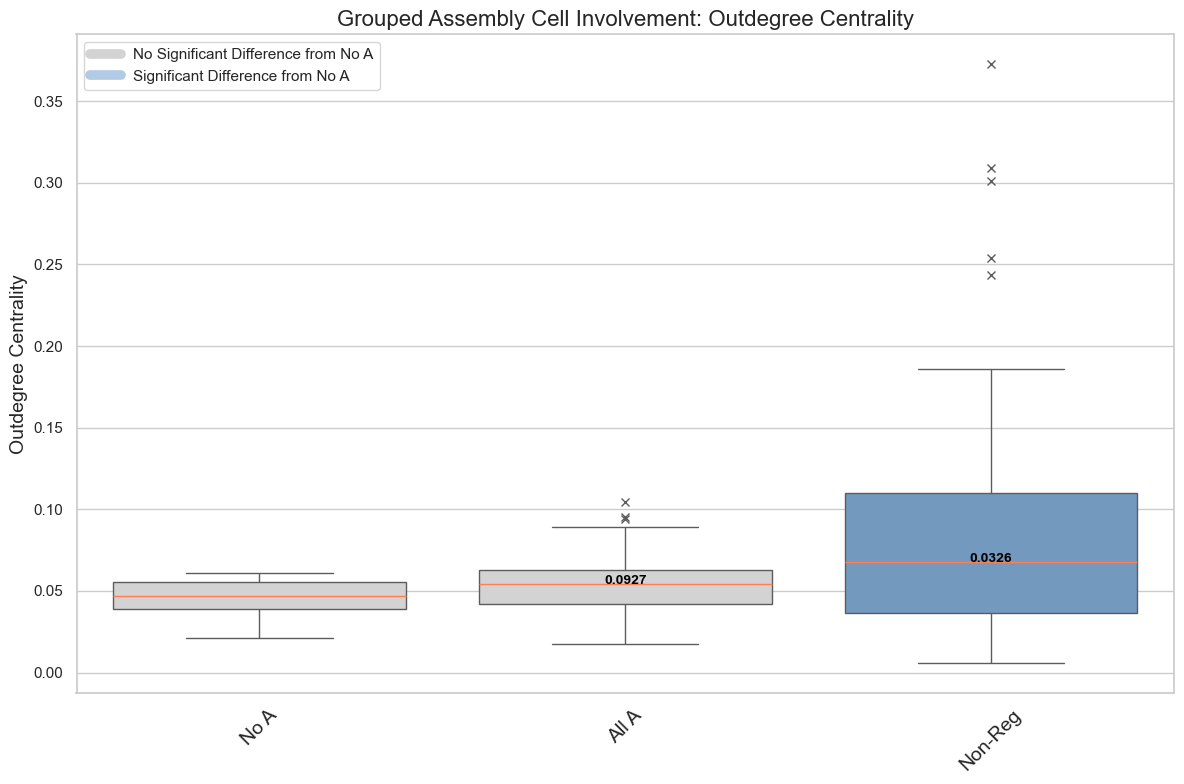

In [61]:
produce_centrality_plot(input_centrality_dict = outdegree_centrality_by_membership,
                        outdegree = True,
                        indegree = False, 
                        closeness = False, 
                        betweeness = False,
                        grouped = False,
                        show_p_vals = True, 
                        fdr_correction = True,
                        save_fig = True)

produce_centrality_plot(input_centrality_dict = outdegree_centrality_by_grouped_membership,
                        outdegree = True,
                        indegree = False, 
                        closeness = False, 
                        betweeness = False,
                        grouped = True,
                        show_p_vals = True, 
                        fdr_correction = True,
                        include_non_registered = True,
                        save_fig = True)

[       nan 0.09512463 0.29701617 0.18668901 0.66589185 0.63577291
 0.48461428 0.51538572 0.47898363]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/2325728411.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


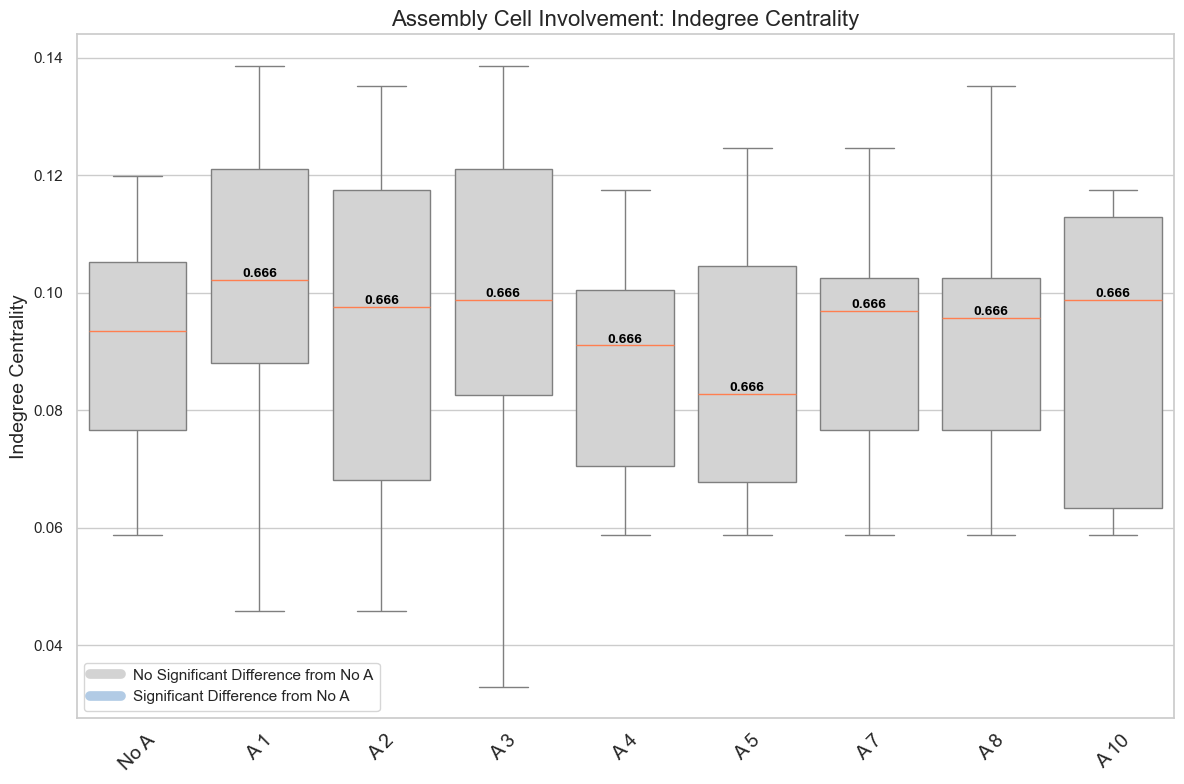

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/2325728411.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


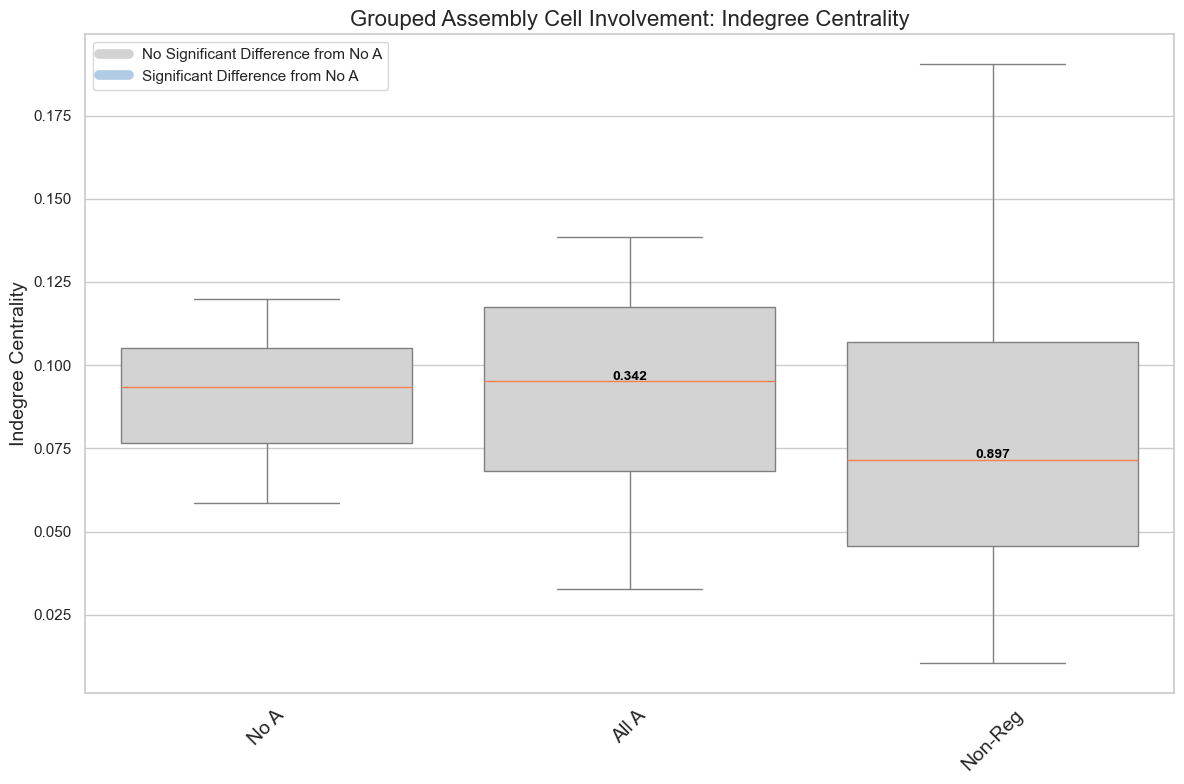

In [62]:
produce_centrality_plot(input_centrality_dict = indegree_centrality_by_membership,
                        outdegree = False,
                        indegree = True, 
                        closeness = False, 
                        betweeness = False,
                        grouped = False,
                        show_p_vals = True, 
                        fdr_correction = True,
                        save_fig = True)

produce_centrality_plot(input_centrality_dict = indegree_centrality_by_grouped_membership,
                        outdegree = False,
                        indegree = True, 
                        closeness = False, 
                        betweeness = False,
                        grouped = True,
                        show_p_vals = True, 
                        fdr_correction = True,
                        include_non_registered = True,
                        save_fig = True)

[       nan 0.04257946 0.5        0.23412832 0.31046407 0.66433895
 0.39356826 0.3080146  0.54197446]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/2325728411.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


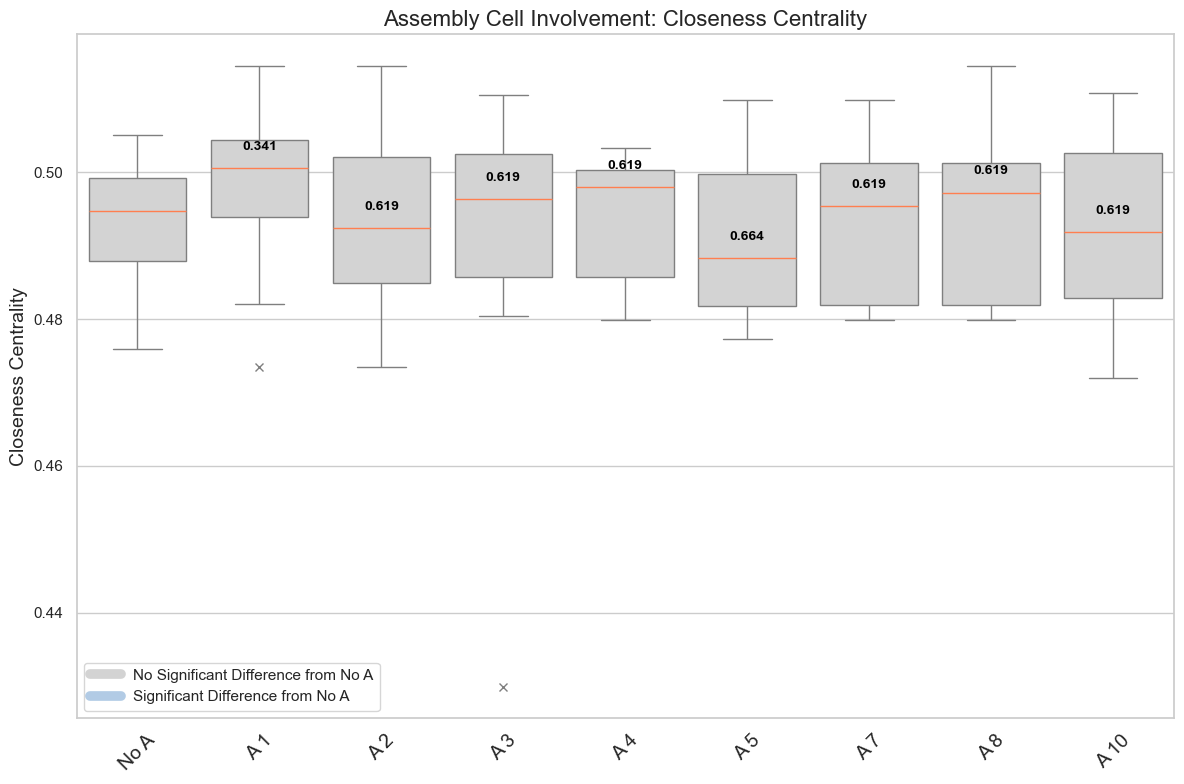

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/2325728411.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


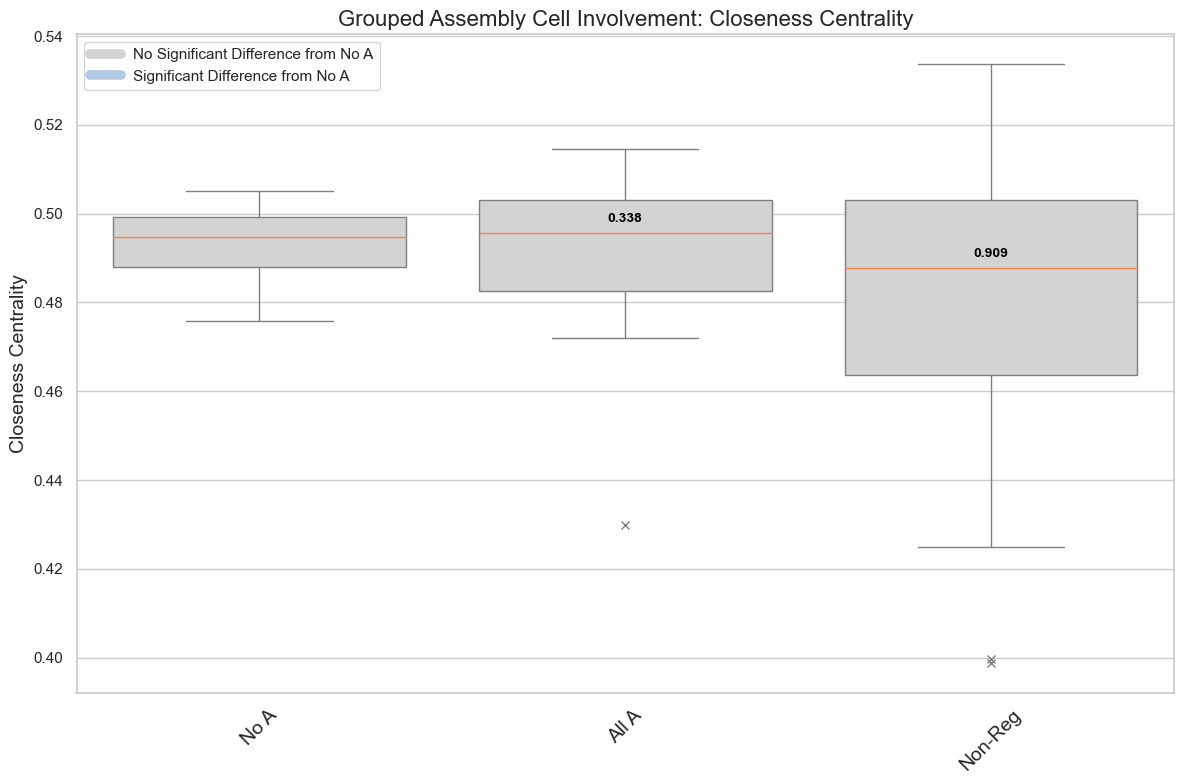

In [63]:
produce_centrality_plot(input_centrality_dict = closeness_centrality_by_membership,
                        outdegree = False,
                        indegree = False, 
                        closeness = True, 
                        betweeness = False,
                        grouped = False,
                        show_p_vals = True, 
                        fdr_correction = True,
                        save_fig = True)

produce_centrality_plot(input_centrality_dict = closeness_centrality_by_grouped_membership,
                        outdegree = False,
                        indegree = False, 
                        closeness = True, 
                        betweeness = False,
                        grouped = True,
                        show_p_vals = True, 
                        fdr_correction = True,
                        include_non_registered = True,
                        save_fig = True)

[       nan 0.00675588 0.0677965  0.09362452 0.01477929 0.03203875
 0.01031878 0.00435596 0.05692315]


/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/2325728411.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


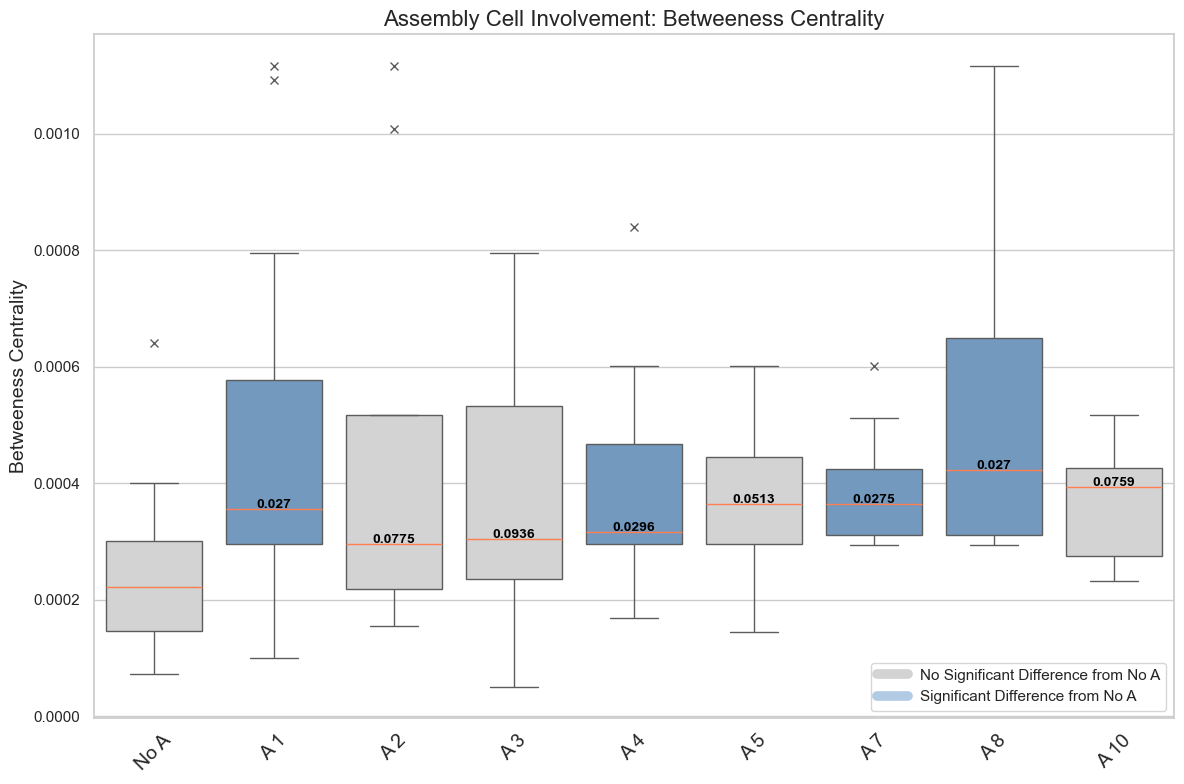

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_9109/2325728411.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, size = 14)


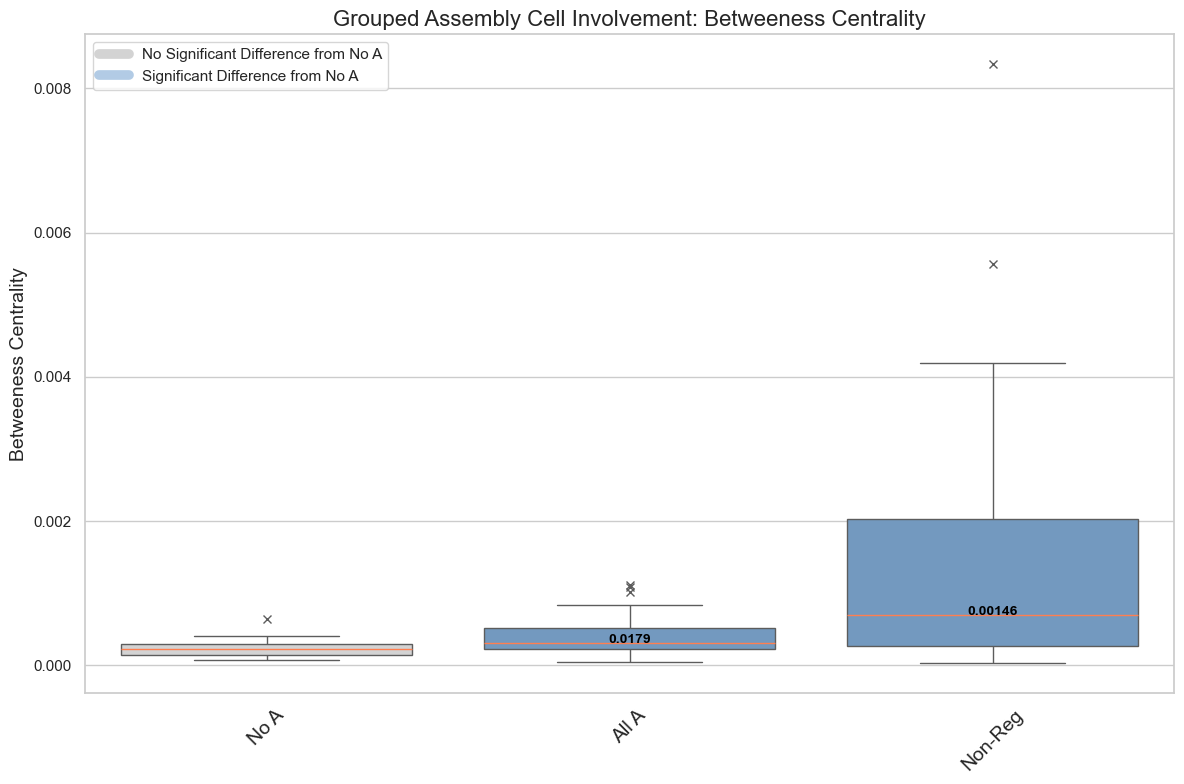

In [64]:
produce_centrality_plot(input_centrality_dict = betweeness_centrality_by_membership,
                        outdegree = False,
                        indegree = False, 
                        closeness = False, 
                        betweeness = True,
                        grouped = False,
                        show_p_vals = True, 
                        fdr_correction = True,
                        save_fig = True)

produce_centrality_plot(input_centrality_dict = betweeness_centrality_by_grouped_membership,
                        outdegree = False,
                        indegree = False, 
                        closeness = False, 
                        betweeness = True,
                        grouped = True,
                        show_p_vals = True, 
                        fdr_correction = True,
                        include_non_registered = True,
                        save_fig = True)